# Baseline Decoder-only transformer experiments

This notebook contains the experiments of the base decoder-only transformer applied in the context of timeseries forecasting. The implementation is a baseline without any adjustments to the attention mechanism. In this notebook, you will find the following experiments:
- **Experiment 1**: 1-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 2**: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 3**: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target
- **Experiment 4**: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series
- **Experiment 5**: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target
- **Experiment 6**: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target
- **Experiment 7**: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

For visualization and inspection purposes, we use 3 decoder layers and a single attention head

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import src.Datasets.SyntheticDataset as SD
from src.Transformer.DecoderOnly import PointDecoderOnlyTransformer
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn

## Experiment 1: one-step prediction on `SimplePeriodicDataset` with overlapping source and target 

### Configs

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model)
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                             # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [3]:
dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

# dataset.fX = (dataset.fX - torch.mean(dataset.fX, dim=0, keepdim=True)) / torch.std(dataset.fX, dim=0, keepdim=True)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

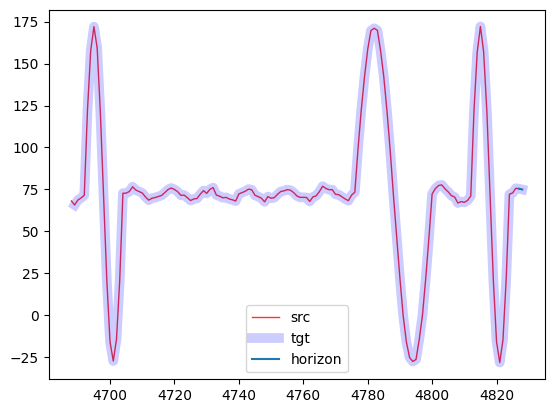

In [4]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [5]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [6]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=2409.5866	val_loss=1506.0944	R_p=['0.2750', '0.2791']
epoch=1	train_loss=1097.5514	val_loss=547.1777	R_p=['0.1994', '0.2120']
epoch=2	train_loss=395.2002	val_loss=191.0868	R_p=['0.1019', '0.0998']
epoch=3	train_loss=240.2379	val_loss=187.2874	R_p=['0.0956', '0.0895']
epoch=4	train_loss=210.2453	val_loss=178.2646	R_p=['0.0949', '0.0809']
epoch=5	train_loss=200.4095	val_loss=167.8883	R_p=['0.0910', '0.0830']
epoch=6	train_loss=192.1085	val_loss=169.8479	R_p=['0.0876', '0.0859']
epoch=7	train_loss=191.5572	val_loss=172.2232	R_p=['0.0882', '0.0946']
epoch=8	train_loss=183.2463	val_loss=152.9326	R_p=['0.0846', '0.0877']
epoch=9	train_loss=175.5553	val_loss=149.6650	R_p=['0.0853', '0.0755']
epoch=10	train_loss=172.3098	val_loss=152.3911	R_p=['0.0843', '0.0749']
epoch=11	train_loss=167.3246	val_loss=142.5916	R_p=['0.0816', '0.0786']
epoch=12	train_loss=162.0613	val_loss=152.3963	R_p=['0.0840', '0.0774']
epoch=13	train_loss=159.5162	val_loss=153.9734	R_p=['0.0834', '0.0937']

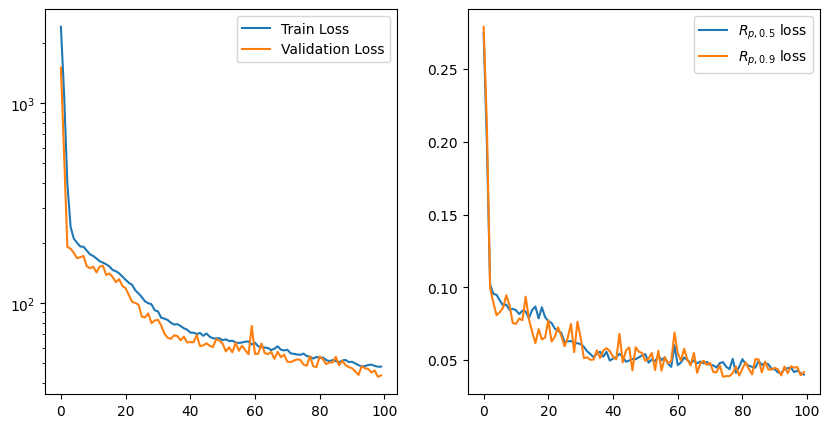

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [8]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, r_ps

(39.82188623046875, tensor([0.0381, 0.0397], device='cuda:0'))

### Predict

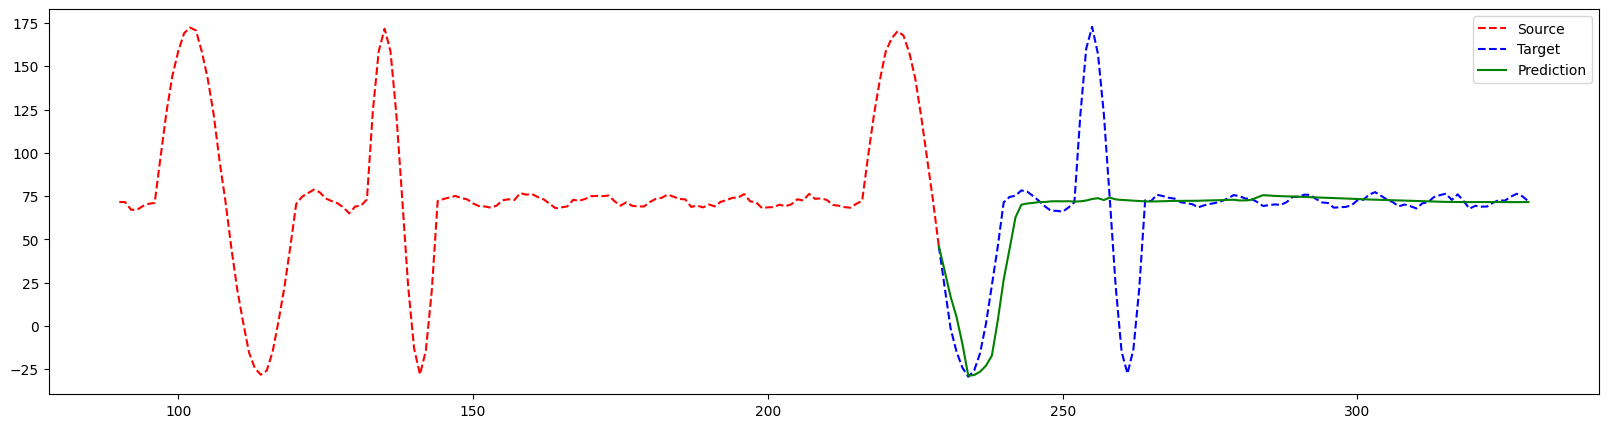

In [9]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

In [10]:
inspect_step = 0

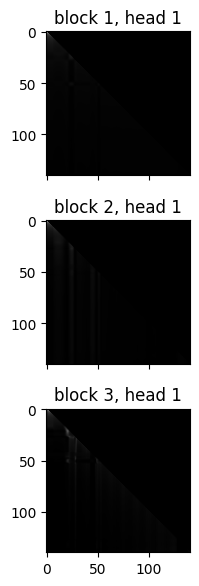

In [11]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

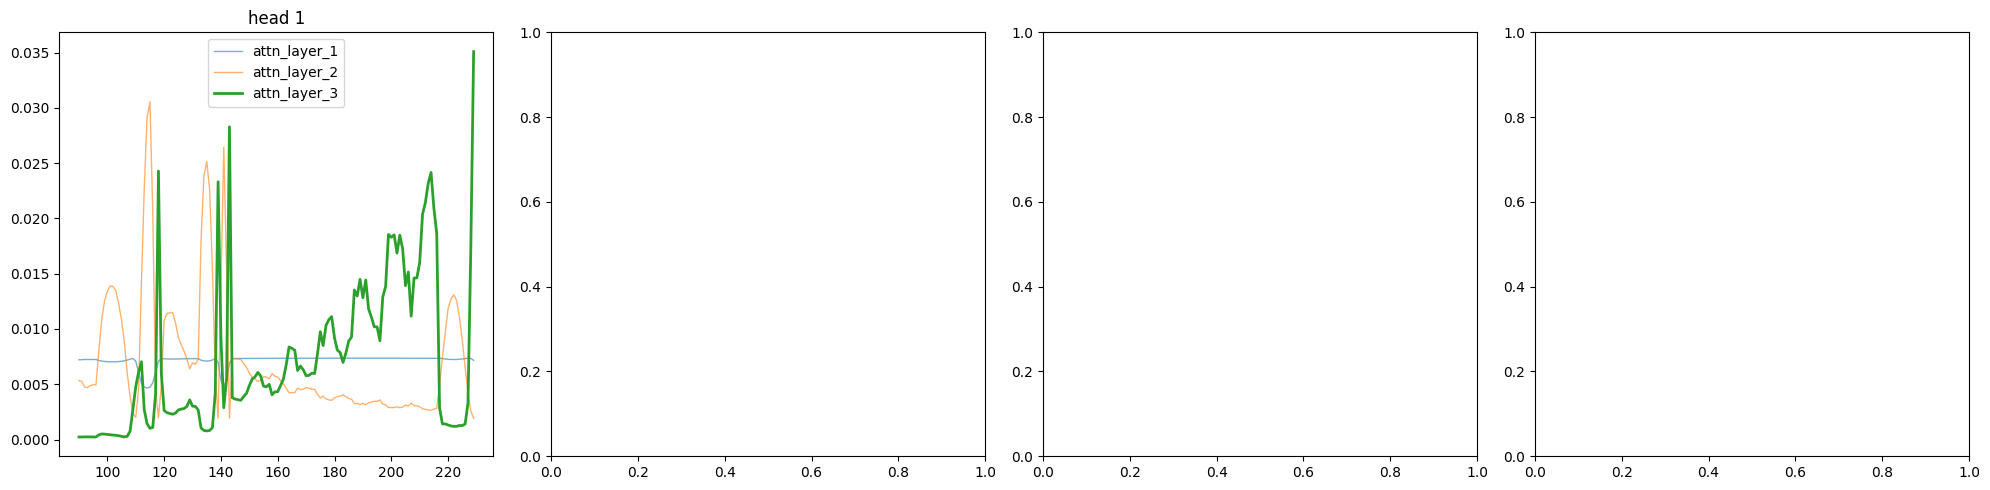

In [13]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -1, :].cpu() # index (inspect_step, attn_layer_i, sample_0, head_j, last row, :)
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

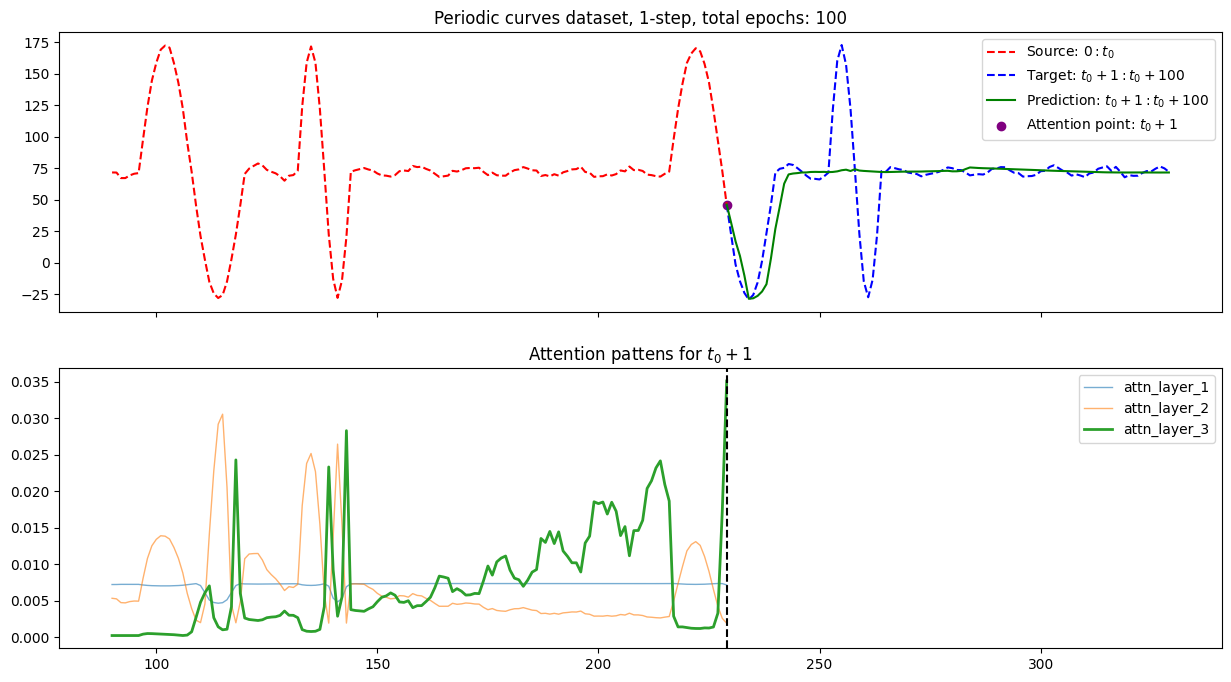

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

# fig.savefig("../../img/baseline_dec_only/dec_only_baseline_attn_1pred_at_once.pdf", dpi=1200)

## Experiment 2: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target

### Configs

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.95                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [72]:
dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

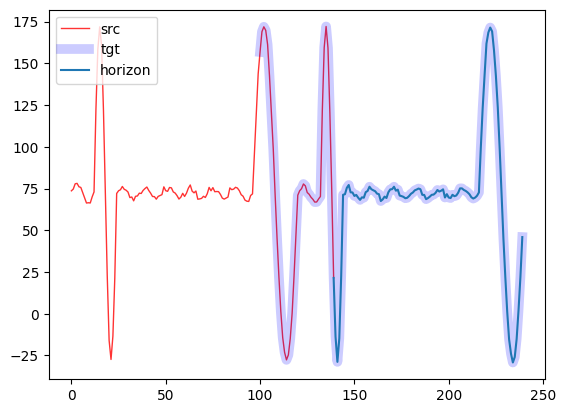

In [73]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [74]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

### Training

In [75]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=2137.6870	val_loss=1497.6384	R_p=['0.2719', '0.2729']
epoch=1	train_loss=1503.7625	val_loss=1489.8606	R_p=['0.2759', '0.2615']
epoch=2	train_loss=1473.7940	val_loss=1395.6954	R_p=['0.2859', '0.3162']
epoch=3	train_loss=1407.2627	val_loss=1329.2883	R_p=['0.2853', '0.2712']
epoch=4	train_loss=1331.0754	val_loss=1200.9661	R_p=['0.2655', '0.3013']
epoch=5	train_loss=1167.7049	val_loss=992.1928	R_p=['0.2383', '0.2828']
epoch=6	train_loss=983.2641	val_loss=902.1582	R_p=['0.1997', '0.1894']
epoch=7	train_loss=936.3518	val_loss=854.3216	R_p=['0.1919', '0.1934']
epoch=8	train_loss=891.7661	val_loss=801.1924	R_p=['0.1971', '0.1921']
epoch=9	train_loss=839.2603	val_loss=739.0139	R_p=['0.1878', '0.1951']
epoch=10	train_loss=800.9400	val_loss=715.4549	R_p=['0.1806', '0.1681']
epoch=11	train_loss=769.3243	val_loss=678.7465	R_p=['0.1793', '0.1762']
epoch=12	train_loss=729.6261	val_loss=671.3424	R_p=['0.1794', '0.1630']
epoch=13	train_loss=687.2653	val_loss=585.4000	R_p=['0.1669', '

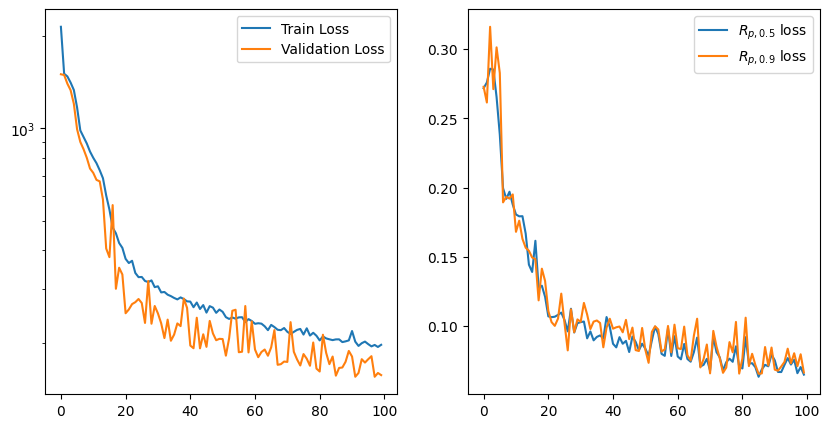

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [77]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, r_ps

(172.30973657226562, tensor([0.0678, 0.0684], device='cuda:0'))

### Predict

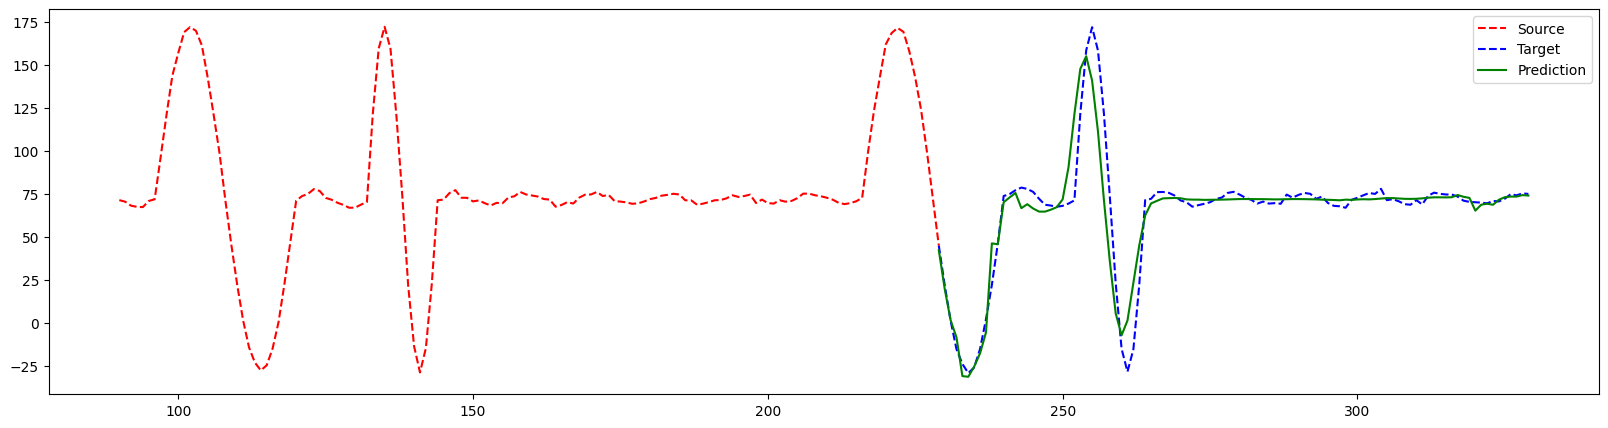

In [78]:
idx = 90
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift-1:].squeeze().cpu()
    
    tgt_X = tgt_X[:, -shift-1:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift-1:].squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [79]:
inspect_step = 0

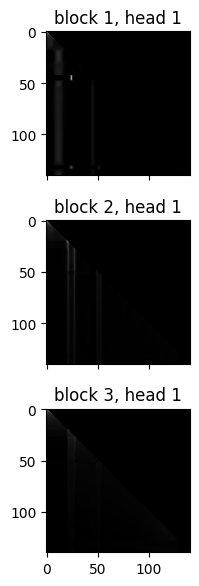

In [80]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

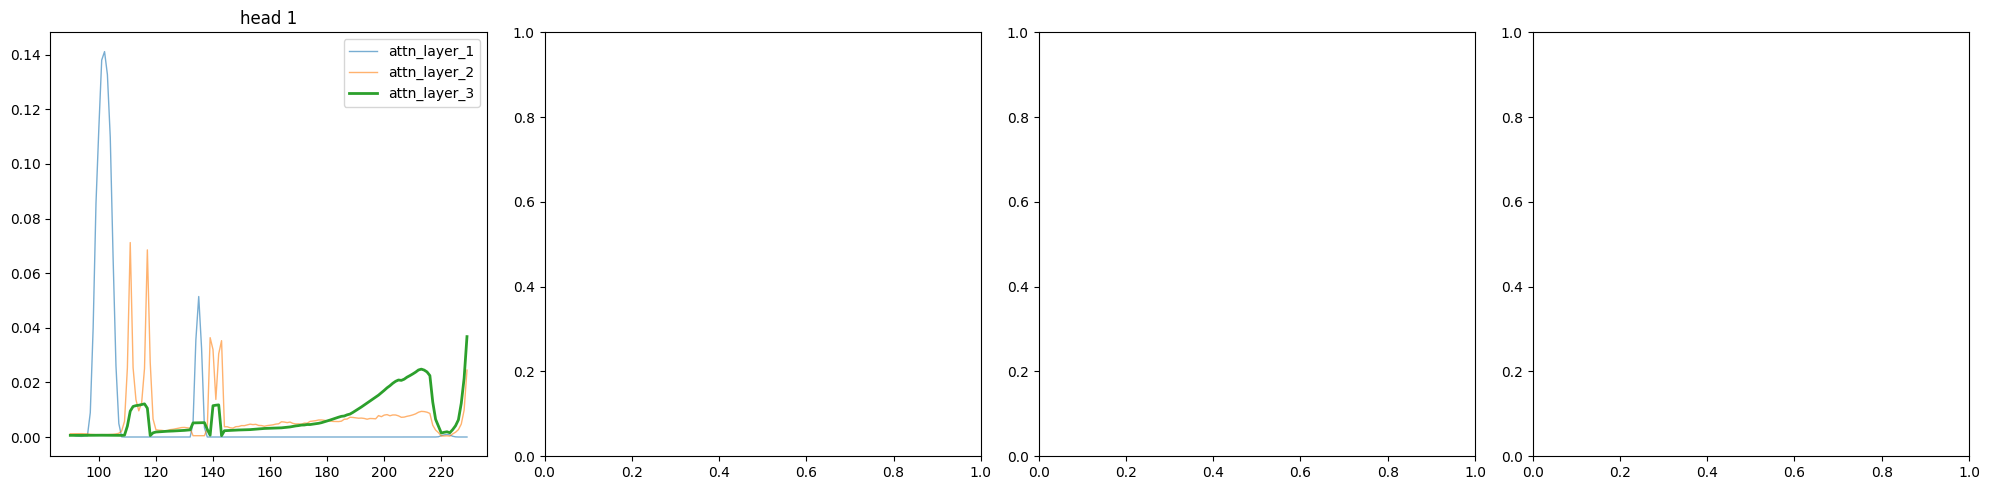

In [82]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

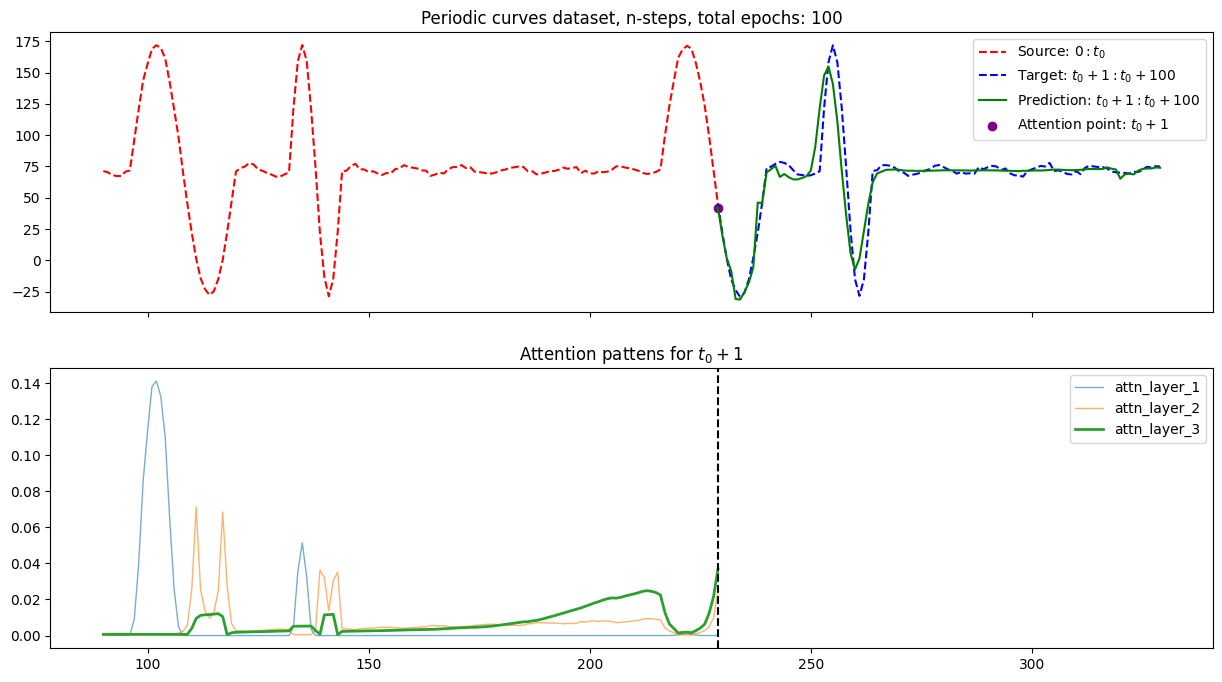

In [84]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
    ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")

ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/dec_only_baseline_attn_{shift}pred_at_once.pdf", dpi=1200)

## Experiment 3: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target 

In [85]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [86]:
dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

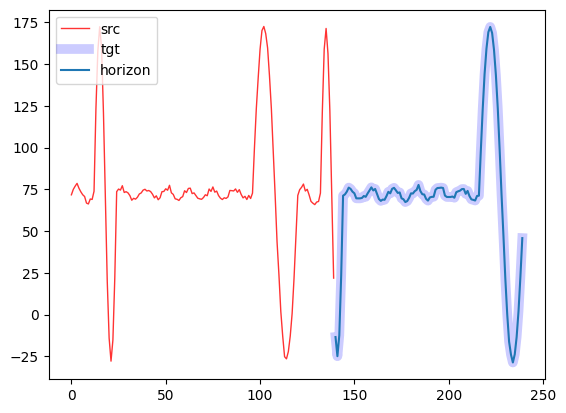

In [87]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [89]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

### Training

In [90]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=2137.5888	val_loss=1511.1295	R_p=['0.2745', '0.2736']
epoch=1	train_loss=1504.1483	val_loss=1495.4257	R_p=['0.2752', '0.2691']
epoch=2	train_loss=1451.1377	val_loss=1338.2028	R_p=['0.2722', '0.2886']
epoch=3	train_loss=1327.8747	val_loss=1233.2933	R_p=['0.2618', '0.2733']
epoch=4	train_loss=1239.7833	val_loss=1196.3487	R_p=['0.2505', '0.2696']
epoch=5	train_loss=1212.1924	val_loss=1162.7458	R_p=['0.2516', '0.2484']
epoch=6	train_loss=1195.3589	val_loss=1170.6647	R_p=['0.2524', '0.2548']
epoch=7	train_loss=1187.4773	val_loss=1166.8263	R_p=['0.2523', '0.2593']
epoch=8	train_loss=1068.7876	val_loss=935.5669	R_p=['0.2087', '0.1944']
epoch=9	train_loss=890.8580	val_loss=803.6879	R_p=['0.1893', '0.1796']
epoch=10	train_loss=794.9483	val_loss=748.2278	R_p=['0.1907', '0.1972']
epoch=11	train_loss=754.9296	val_loss=758.4262	R_p=['0.1937', '0.1804']
epoch=12	train_loss=705.7527	val_loss=732.7177	R_p=['0.1916', '0.1684']
epoch=13	train_loss=657.3146	val_loss=539.7462	R_p=['0.16

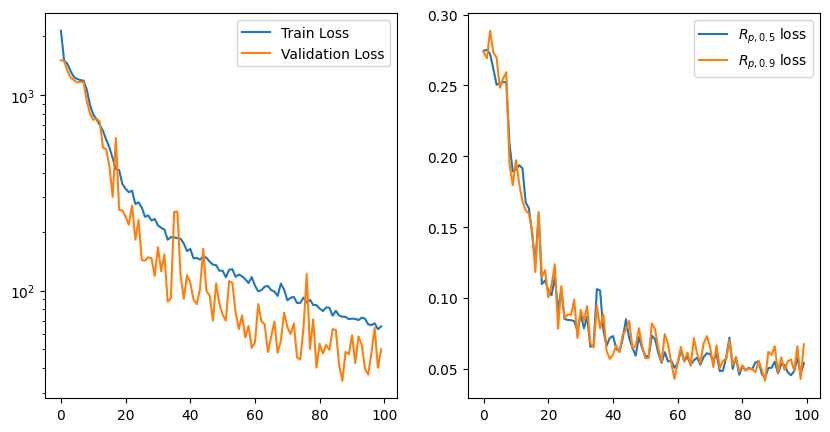

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [92]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(50.621023712158205, tensor([0.0541, 0.0667], device='cuda:0'))

### Predict

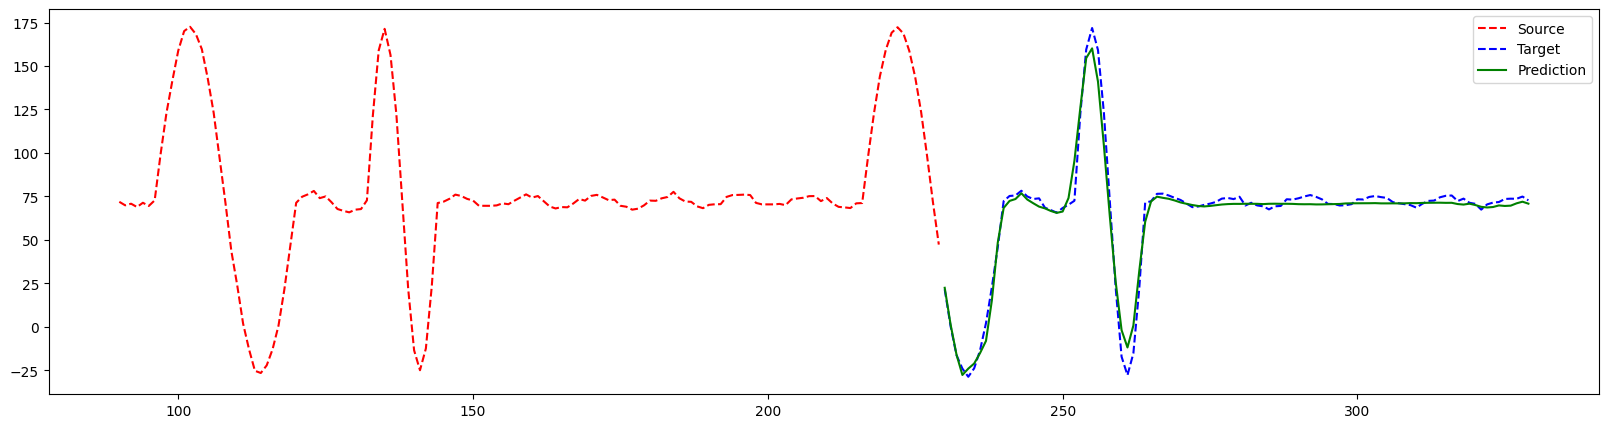

In [93]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [94]:
inspect_step = 0

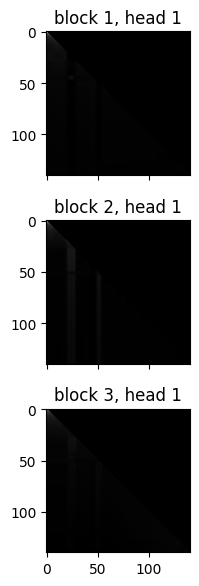

In [95]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

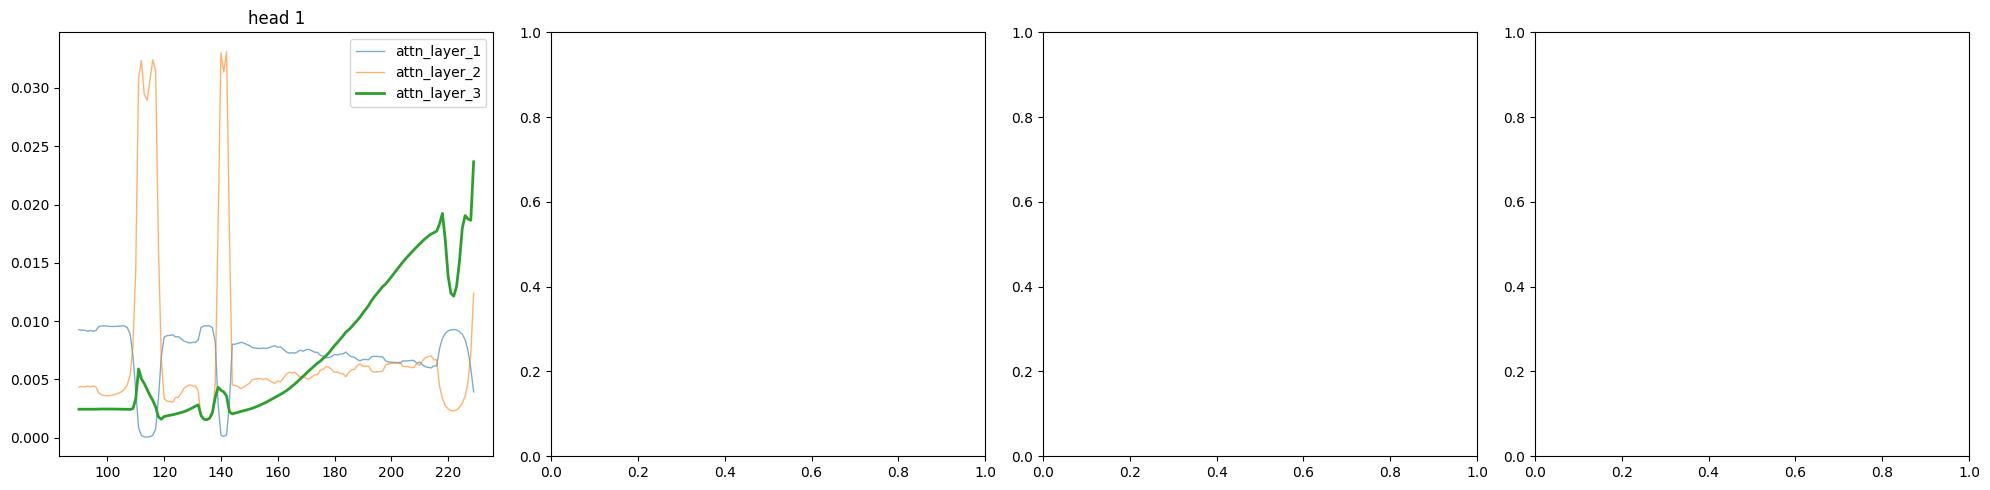

In [97]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

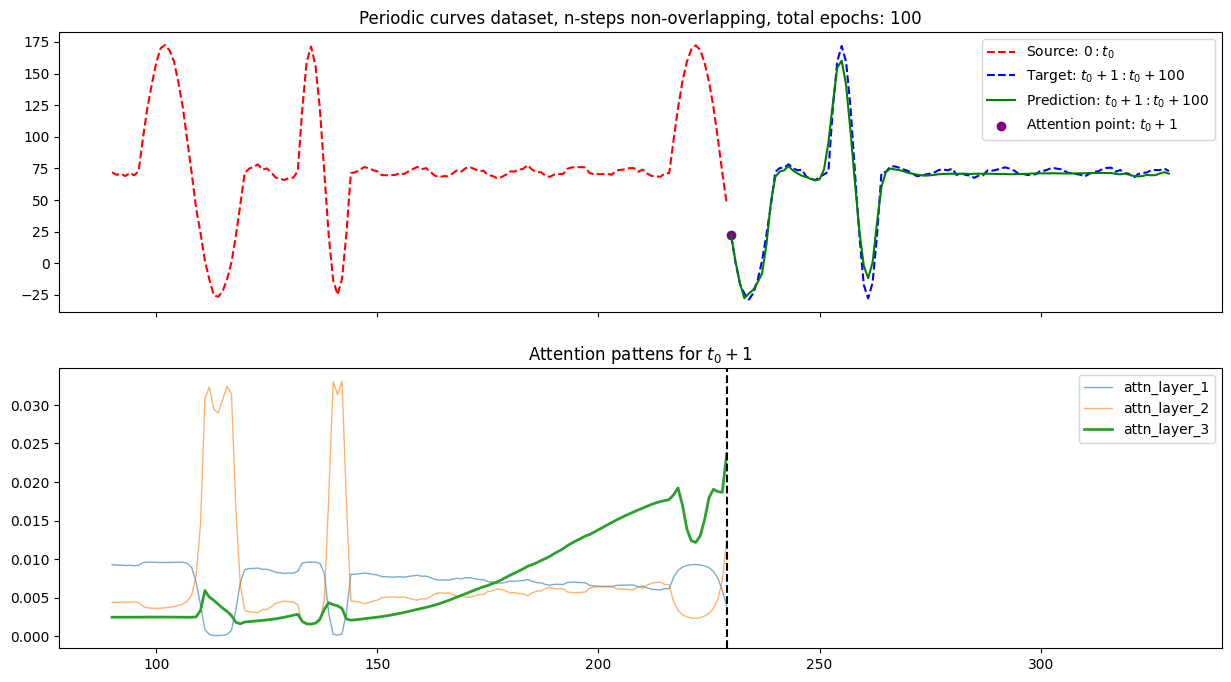

In [99]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 4: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series

### Configs

In [105]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 20                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [106]:
dataset = SD.MultivarPeriodicDataset(len_timeseries=total_length, n_timeseries=n_timeseries, seq_len=seq_len, shift=shift, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 20]),
 torch.Size([100, 1]),
 torch.Size([100, 20]))

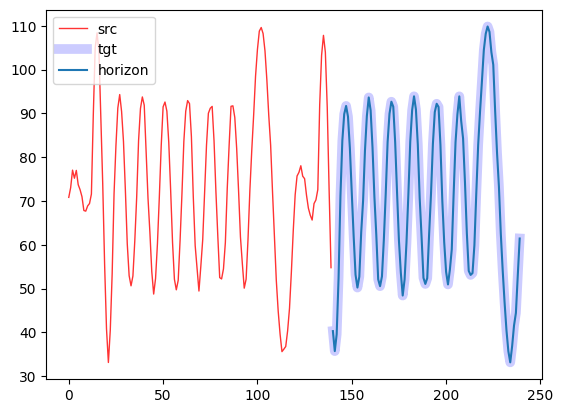

In [107]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

ith = 0 # i-th time series

plt.plot(src_X, src_fX[:, ith], 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX[:, ith], '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:, ith], tgt_fX[-shift-1:, ith], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

### Training setup

In [108]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

### Training

In [109]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=1769.5020	val_loss=601.6484	R_p=['0.2617', '0.2519']
epoch=1	train_loss=534.1678	val_loss=472.3385	R_p=['0.2411', '0.2248']
epoch=2	train_loss=442.6615	val_loss=381.6554	R_p=['0.2122', '0.2015']
epoch=3	train_loss=373.0964	val_loss=306.1666	R_p=['0.1878', '0.2115']
epoch=4	train_loss=328.8326	val_loss=250.9691	R_p=['0.1655', '0.2043']
epoch=5	train_loss=254.1068	val_loss=304.2682	R_p=['0.1782', '0.2471']
epoch=6	train_loss=206.0247	val_loss=165.3904	R_p=['0.1289', '0.1688']
epoch=7	train_loss=173.1385	val_loss=196.7566	R_p=['0.1420', '0.2071']
epoch=8	train_loss=130.4602	val_loss=132.6269	R_p=['0.1161', '0.1611']
epoch=9	train_loss=111.0439	val_loss=102.1046	R_p=['0.1003', '0.1353']
epoch=10	train_loss=93.9265	val_loss=71.5497	R_p=['0.0850', '0.0922']
epoch=11	train_loss=82.7653	val_loss=59.0674	R_p=['0.0757', '0.0848']
epoch=12	train_loss=70.3358	val_loss=51.8166	R_p=['0.0704', '0.0644']
epoch=13	train_loss=63.4827	val_loss=55.8434	R_p=['0.0746', '0.0844']
epoch=14	

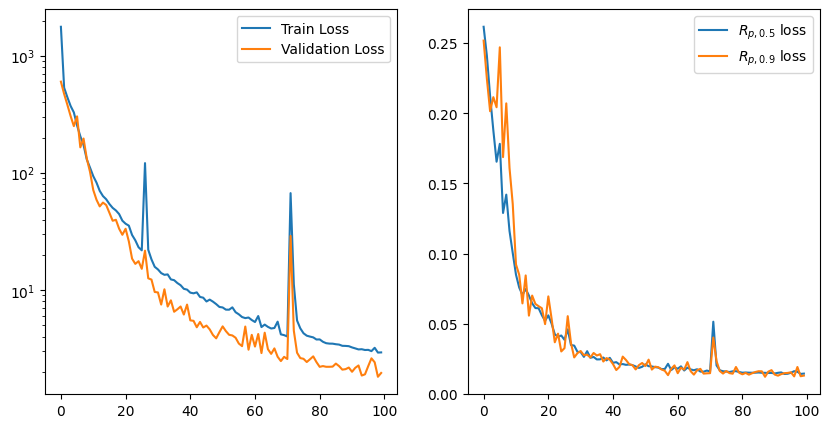

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [111]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(1.9145391540527343, tensor([0.0142, 0.0129], device='cuda:0'))

### Predict

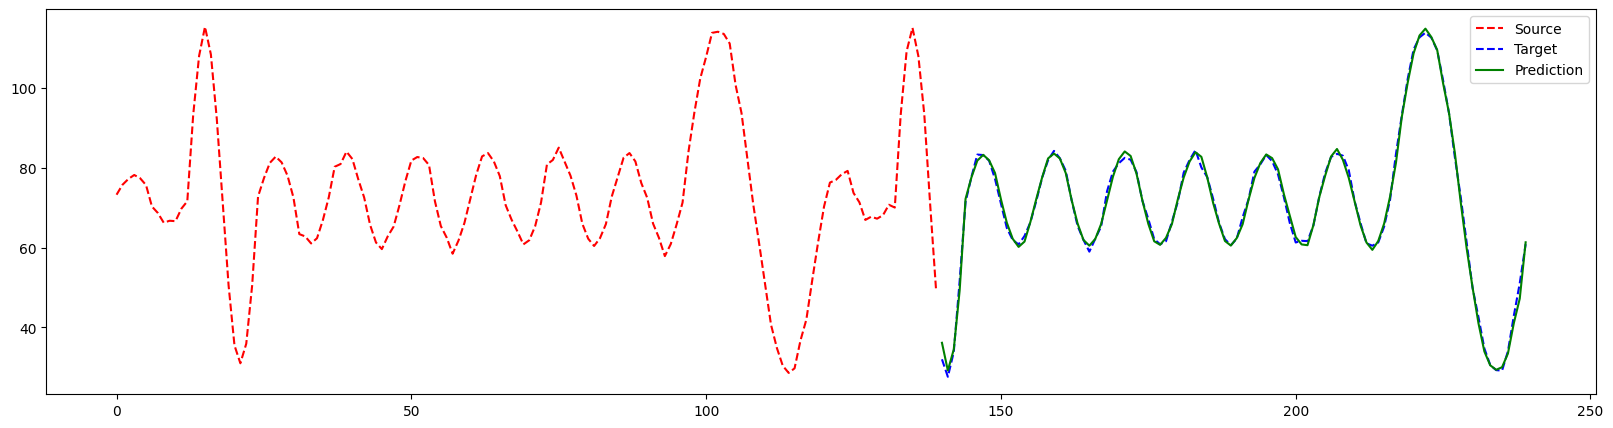

In [112]:
idx = 0 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

ith = 3

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source")
plt.plot(tgt_X, tgt_fX[:, ith], '--b', label="Target")
plt.plot(tgt_X, pred_fX[:, ith], '-g', label="Prediction")
plt.legend()

In [113]:
inspect_step = 0

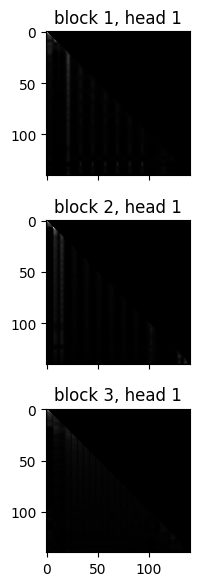

In [114]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

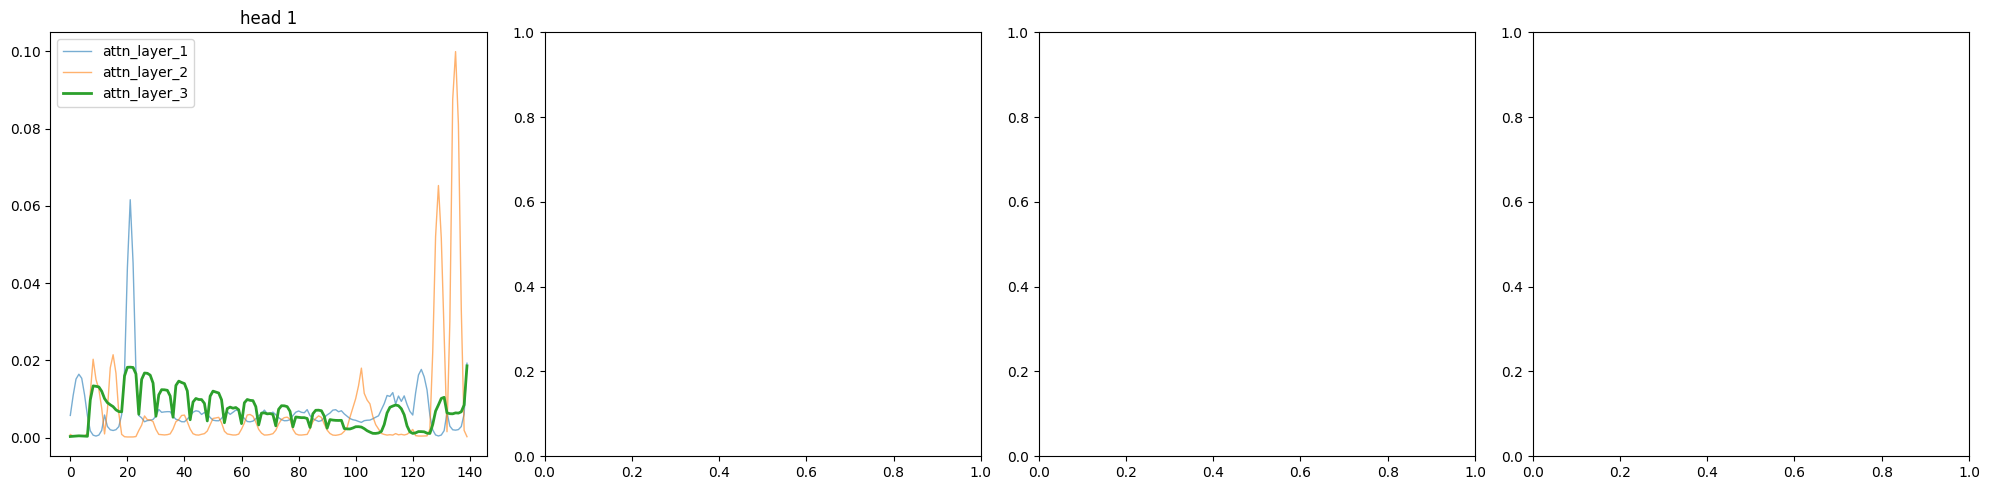

In [115]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

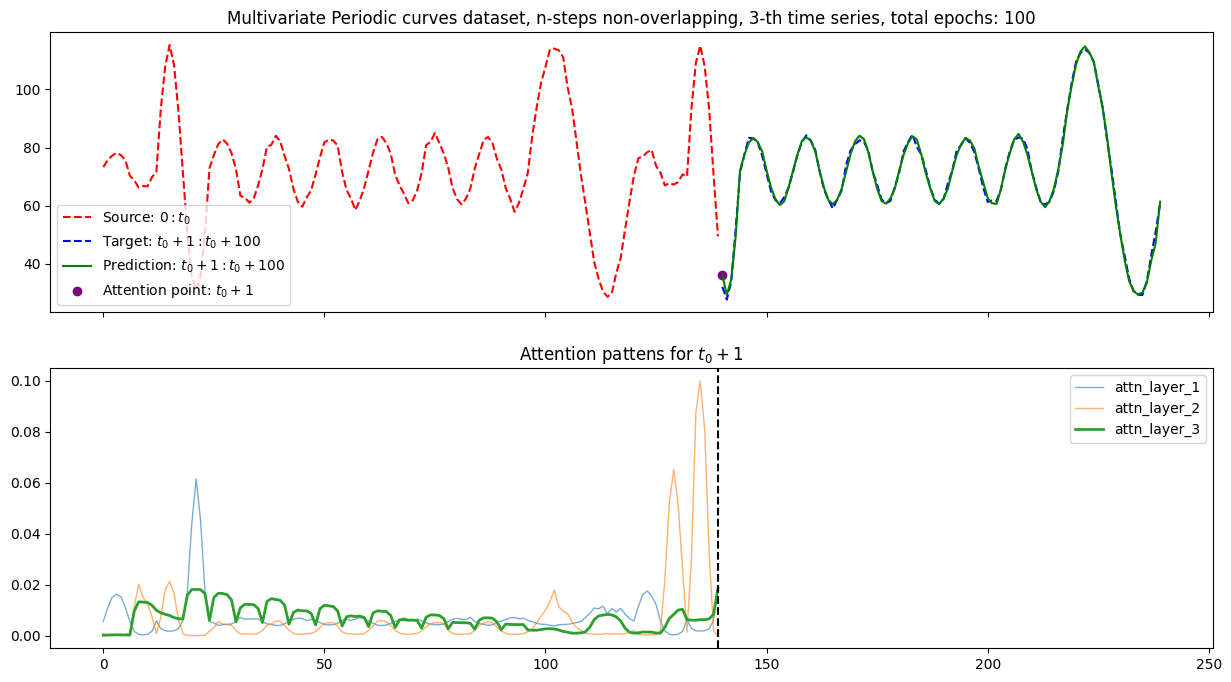

In [118]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX[:, ith], '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX[:, ith], '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step, ith].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Multivariate Periodic curves dataset, n-steps non-overlapping, {ith}-th time series, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/multivar_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 5: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target

In [180]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 50                             # training epochs

### Step function

#### Dataset splits

In [181]:
dataset = SD.StepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

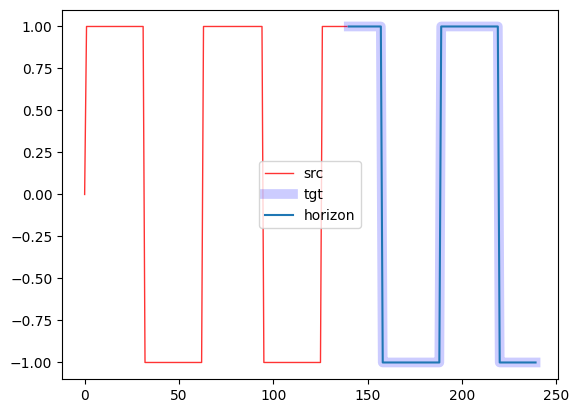

In [182]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [183]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [184]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=1.0545	val_loss=1.0000	R_p=['1.0000', '1.0033']
epoch=1	train_loss=1.0022	val_loss=1.0026	R_p=['1.0002', '1.0416']
epoch=2	train_loss=1.0014	val_loss=1.0000	R_p=['0.9999', '0.9947']
epoch=3	train_loss=1.0027	val_loss=1.0003	R_p=['1.0001', '1.0150']
epoch=4	train_loss=1.0023	val_loss=1.0130	R_p=['1.0005', '1.0920']
epoch=5	train_loss=1.0016	val_loss=1.0003	R_p=['1.0000', '1.0163']
epoch=6	train_loss=1.0013	val_loss=1.0032	R_p=['1.0002', '1.0462']
epoch=7	train_loss=1.0012	val_loss=1.0001	R_p=['1.0000', '1.0096']
epoch=8	train_loss=1.0026	val_loss=1.0026	R_p=['1.0002', '1.0412']
epoch=9	train_loss=1.0009	val_loss=1.0003	R_p=['1.0000', '1.0154']
epoch=10	train_loss=1.0020	val_loss=1.0002	R_p=['0.9999', '0.9872']
epoch=11	train_loss=1.0011	val_loss=1.0002	R_p=['0.9999', '0.9862']
epoch=12	train_loss=1.0013	val_loss=1.0008	R_p=['0.9998', '0.9753']
epoch=13	train_loss=1.0011	val_loss=0.9997	R_p=['0.9999', '1.0007']
epoch=14	train_loss=1.0017	val_loss=1.0028	R_p=['1.0001', 

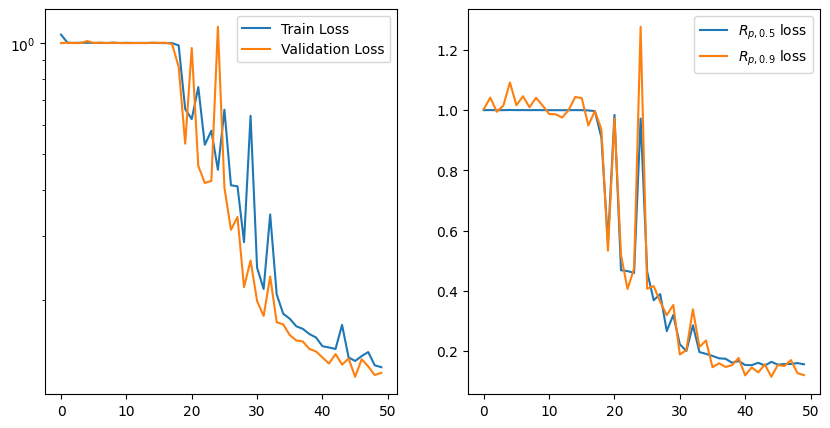

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [186]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.12892532777786256, tensor([0.1573, 0.1236], device='cuda:0'))

#### Predict

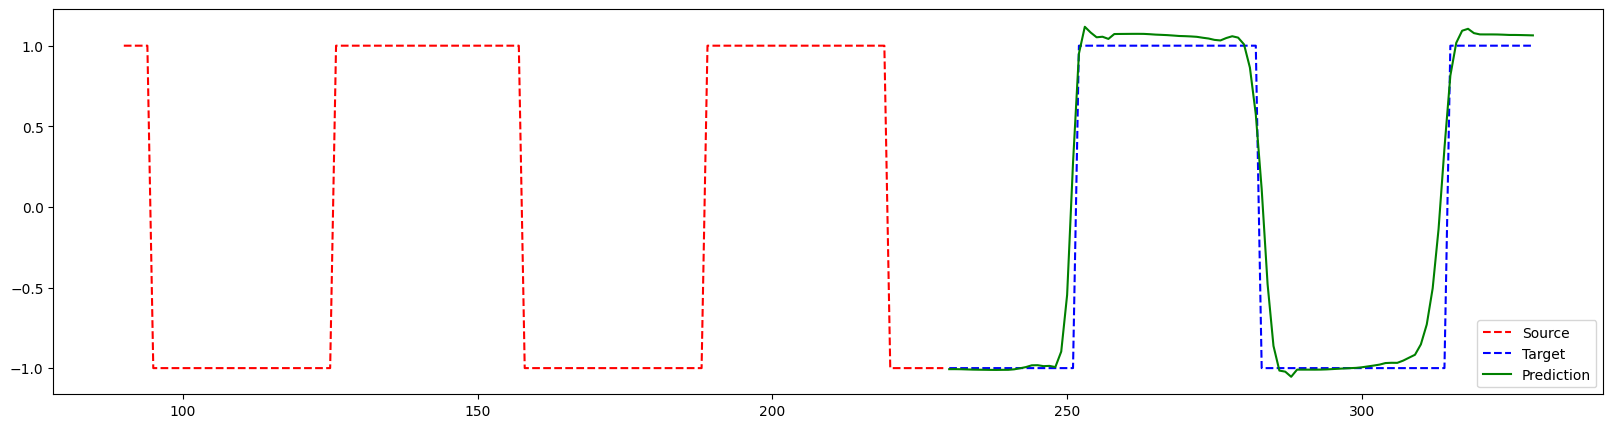

In [187]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [188]:
inspect_step = 0

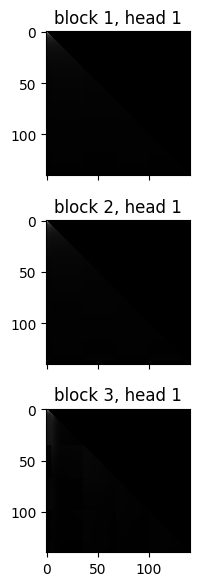

In [189]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

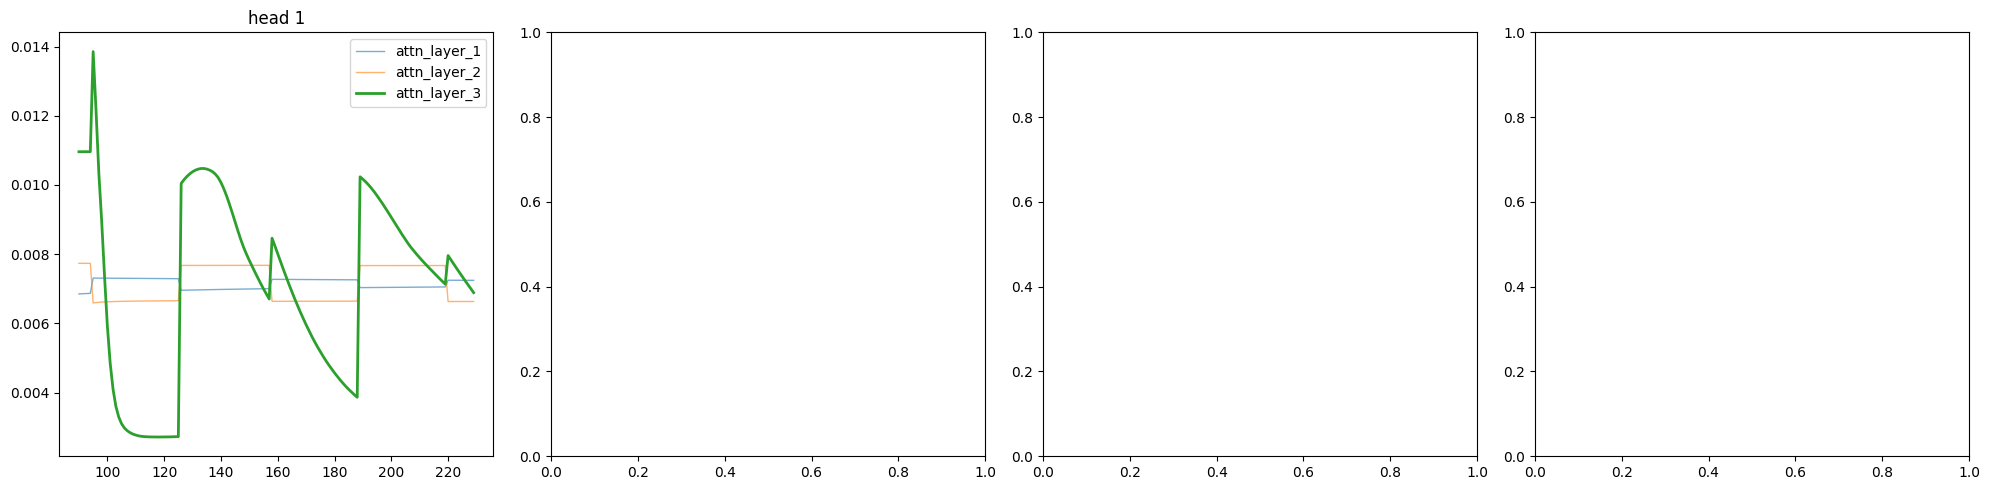

In [190]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

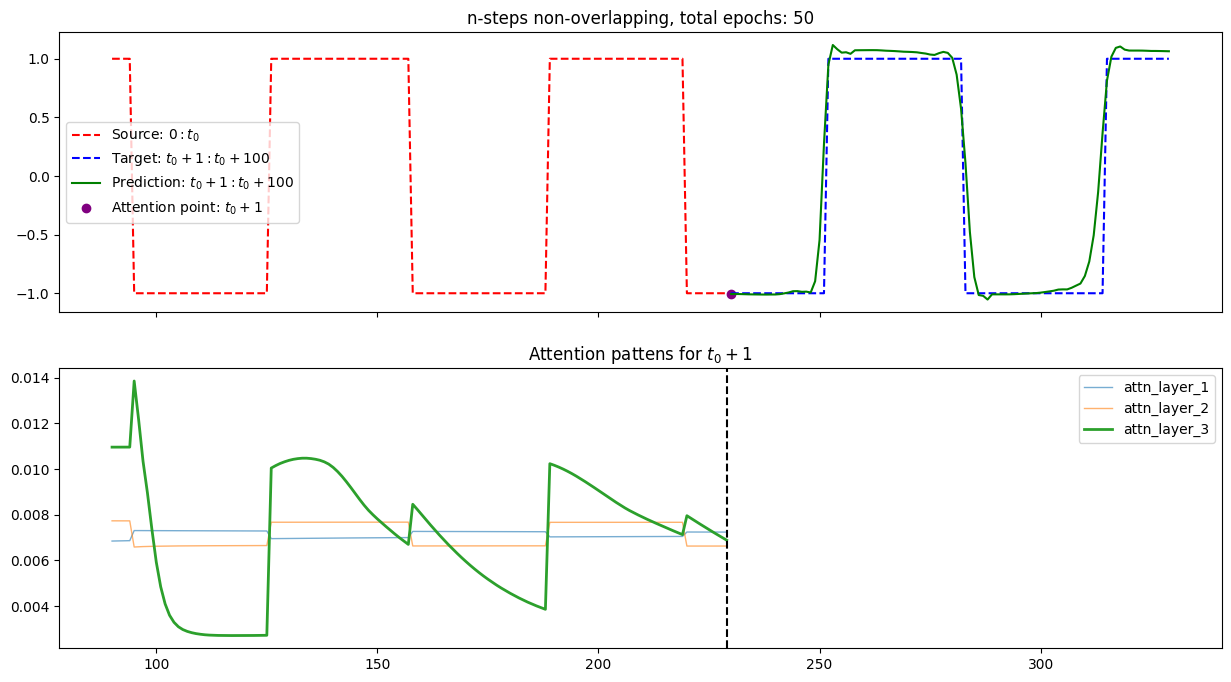

In [192]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/step_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Step function

#### Dataset splits

In [193]:
dataset = SD.DecayingStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.01, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

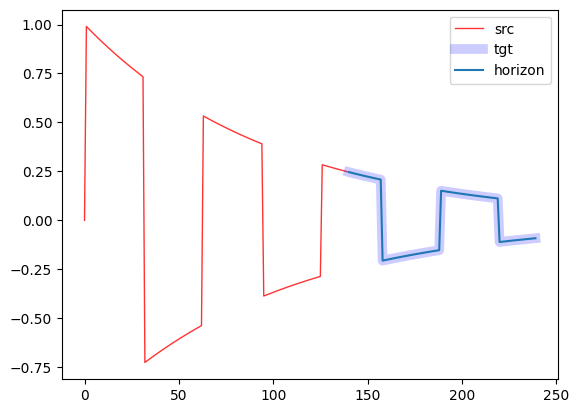

In [194]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [195]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [196]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.0365	val_loss=0.0002	R_p=['1.1404', '0.9866']
epoch=1	train_loss=0.0003	val_loss=0.0002	R_p=['1.2993', '1.0102']
epoch=2	train_loss=0.0002	val_loss=0.0002	R_p=['2.6660', '4.0723']
epoch=3	train_loss=0.0002	val_loss=0.0002	R_p=['1.8984', '1.0970']
epoch=4	train_loss=0.0002	val_loss=0.0002	R_p=['1.0972', '0.9842']
epoch=5	train_loss=0.0002	val_loss=0.0002	R_p=['1.2415', '1.4310']
epoch=6	train_loss=0.0002	val_loss=0.0002	R_p=['1.5080', '1.0404']
epoch=7	train_loss=0.0002	val_loss=0.0002	R_p=['1.4099', '1.7456']
epoch=8	train_loss=0.0002	val_loss=0.0002	R_p=['1.3539', '1.6408']
epoch=9	train_loss=0.0002	val_loss=0.0002	R_p=['1.4022', '1.0252']
epoch=10	train_loss=0.0002	val_loss=0.0002	R_p=['2.5905', '1.2026']
epoch=11	train_loss=0.0002	val_loss=0.0002	R_p=['2.0723', '1.1235']
epoch=12	train_loss=0.0002	val_loss=0.0002	R_p=['1.7696', '2.4137']
epoch=13	train_loss=0.0002	val_loss=0.0002	R_p=['1.6708', '2.2300']
epoch=14	train_loss=0.0002	val_loss=0.0002	R_p=['1.6584', 

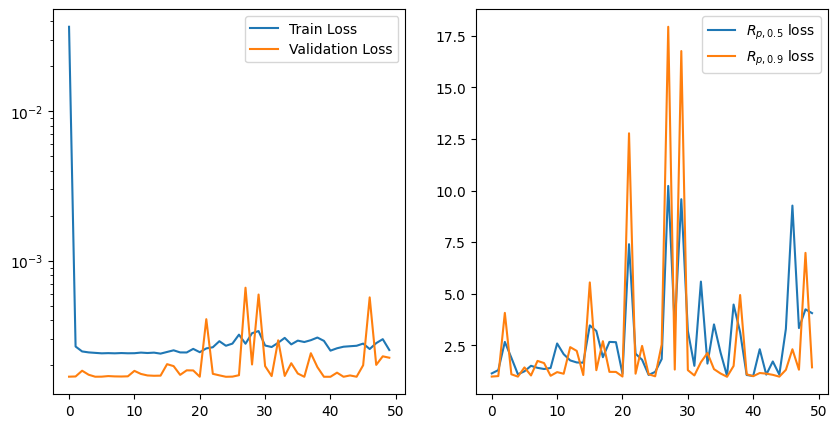

In [200]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [201]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.0002733529368415475, tensor([3.4607, 1.3344], device='cuda:0'))

#### Predict

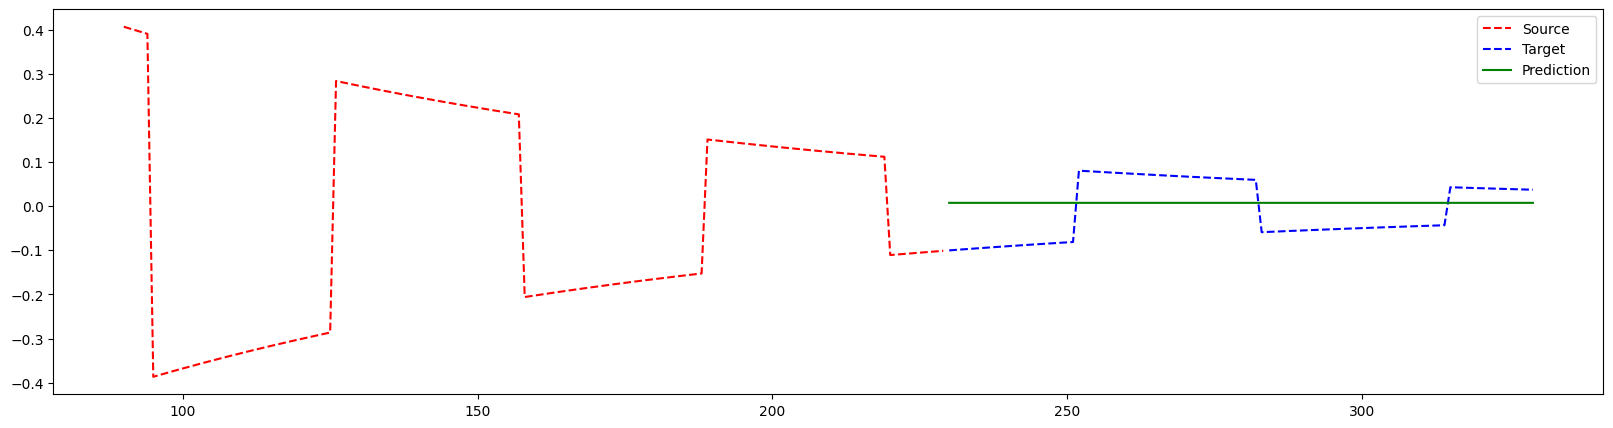

In [202]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [203]:
inspect_step = 0

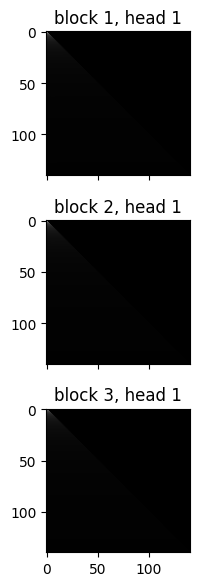

In [204]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

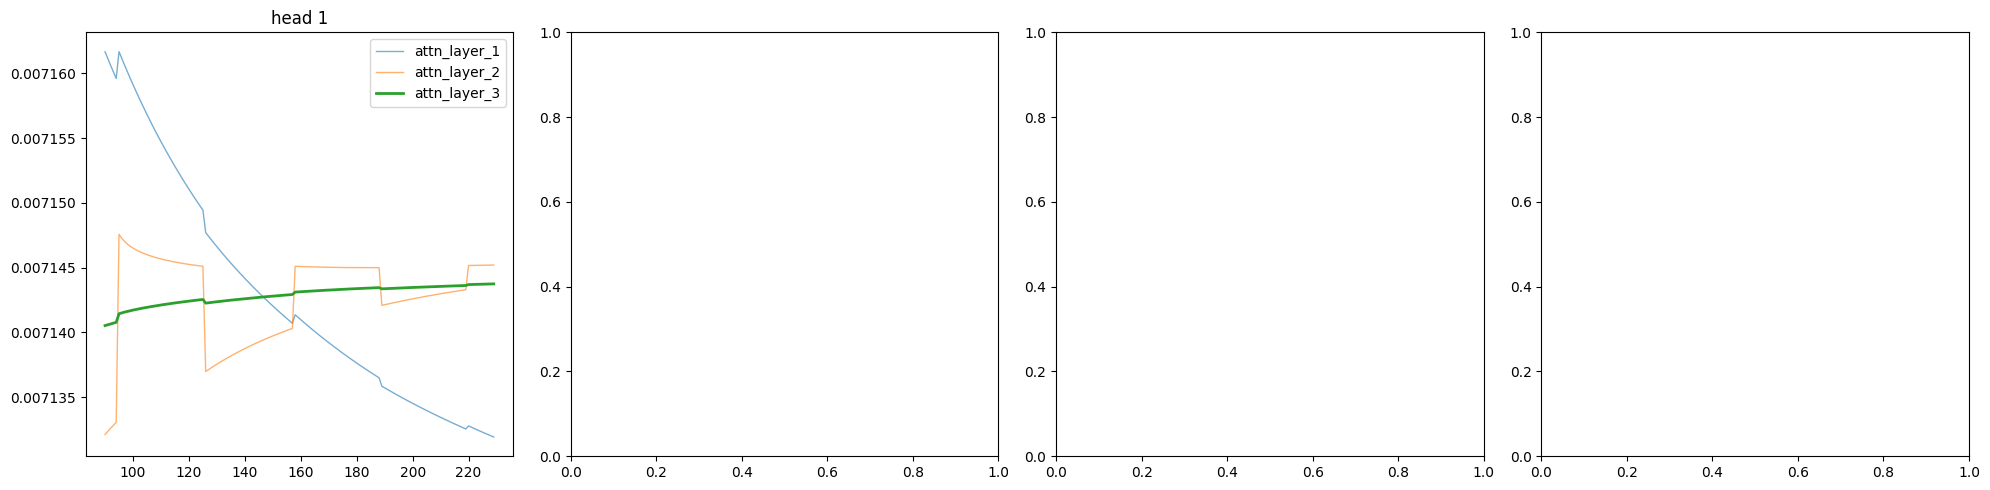

In [205]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

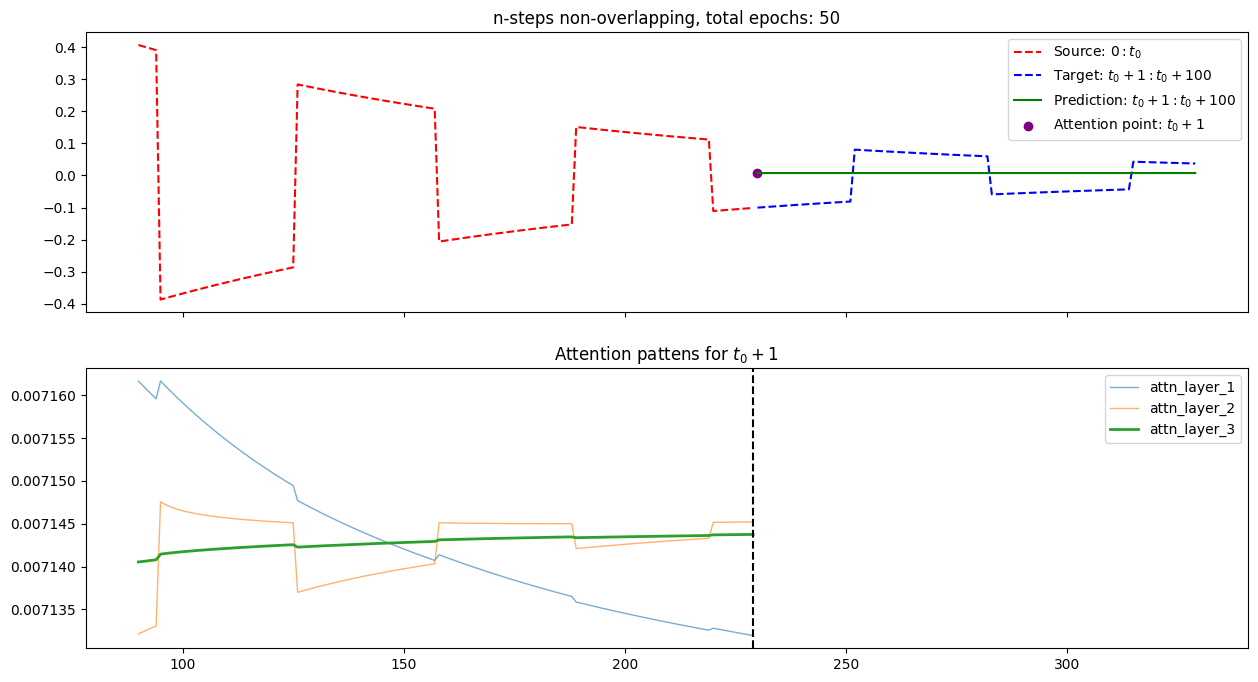

In [209]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/step_decay_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Step function

#### Dataset splits

In [210]:
dataset = SD.MultipleStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

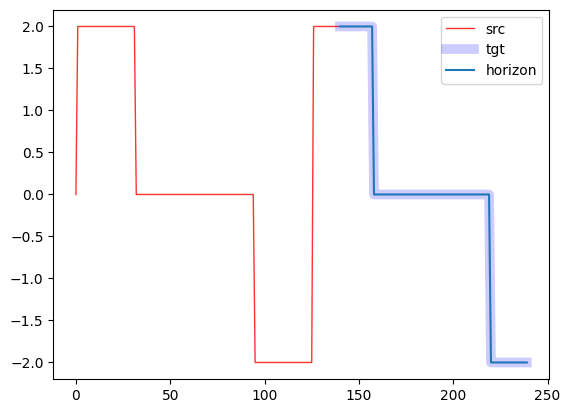

In [211]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [212]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [213]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=2.0422	val_loss=1.9684	R_p=['1.0103', '1.0278']
epoch=1	train_loss=2.0131	val_loss=1.9723	R_p=['1.0333', '1.0869']
epoch=2	train_loss=2.0103	val_loss=1.9832	R_p=['1.0630', '1.1632']
epoch=3	train_loss=2.0125	val_loss=1.9682	R_p=['1.0086', '0.9963']
epoch=4	train_loss=2.0104	val_loss=1.9680	R_p=['1.0005', '1.0010']
epoch=5	train_loss=2.0091	val_loss=1.9824	R_p=['1.0628', '0.9650']
epoch=6	train_loss=2.0093	val_loss=1.9694	R_p=['1.0201', '0.9896']
epoch=7	train_loss=2.0093	val_loss=1.9689	R_p=['1.0153', '1.0407']
epoch=8	train_loss=2.0089	val_loss=1.9764	R_p=['1.0466', '1.1210']
epoch=9	train_loss=2.0083	val_loss=1.9681	R_p=['1.0074', '0.9969']
epoch=10	train_loss=2.0070	val_loss=1.9739	R_p=['1.0394', '1.1026']
epoch=11	train_loss=2.0077	val_loss=1.9688	R_p=['1.0172', '0.9913']
epoch=12	train_loss=2.0077	val_loss=1.9737	R_p=['1.0389', '1.1017']
epoch=13	train_loss=2.0075	val_loss=1.9710	R_p=['1.0306', '1.0806']
epoch=14	train_loss=2.0074	val_loss=1.9643	R_p=['1.0102', 

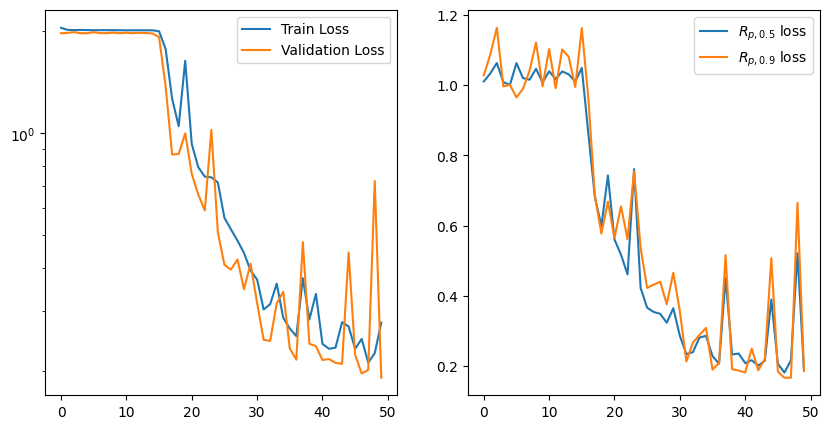

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [215]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.18968653166294097, tensor([0.1795, 0.1818], device='cuda:0'))

#### Predict

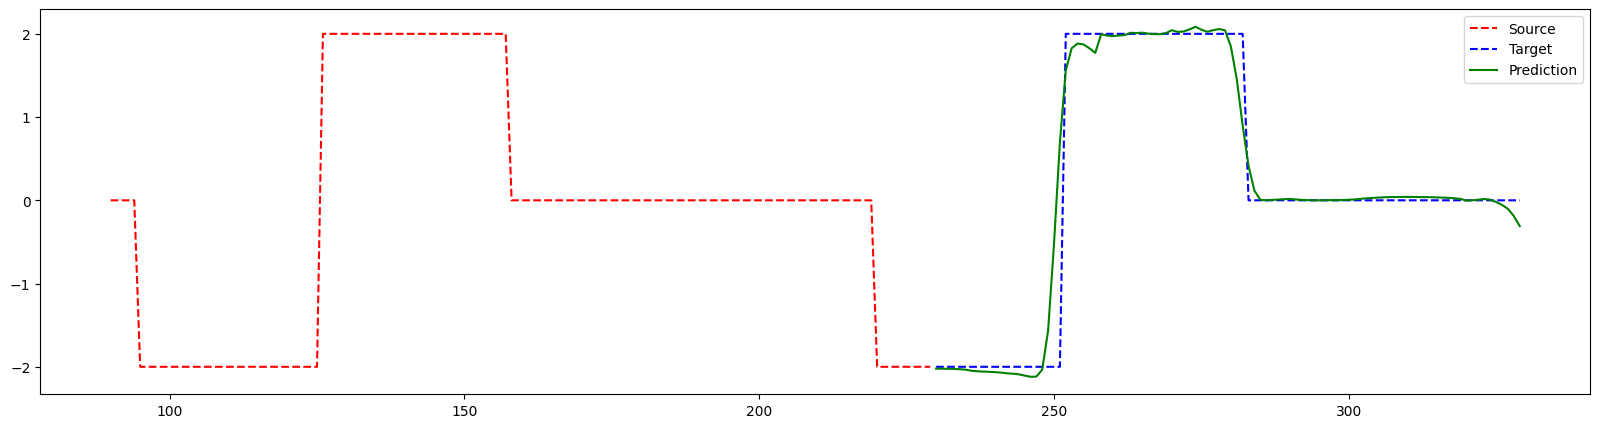

In [216]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [217]:
inspect_step = 0

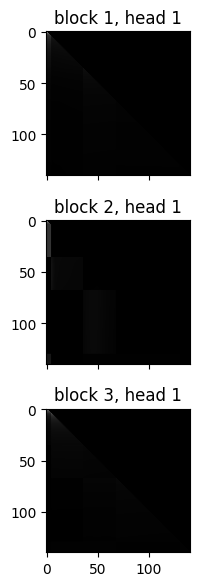

In [218]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

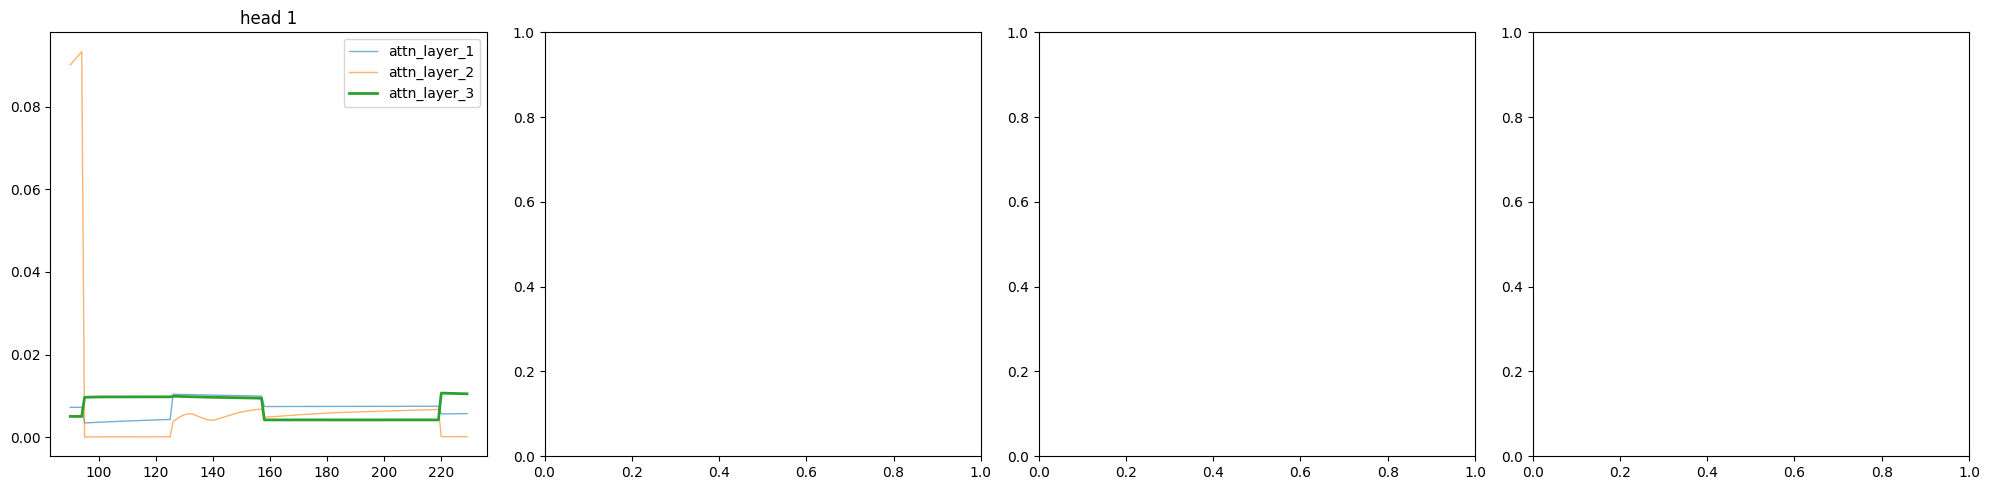

In [219]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

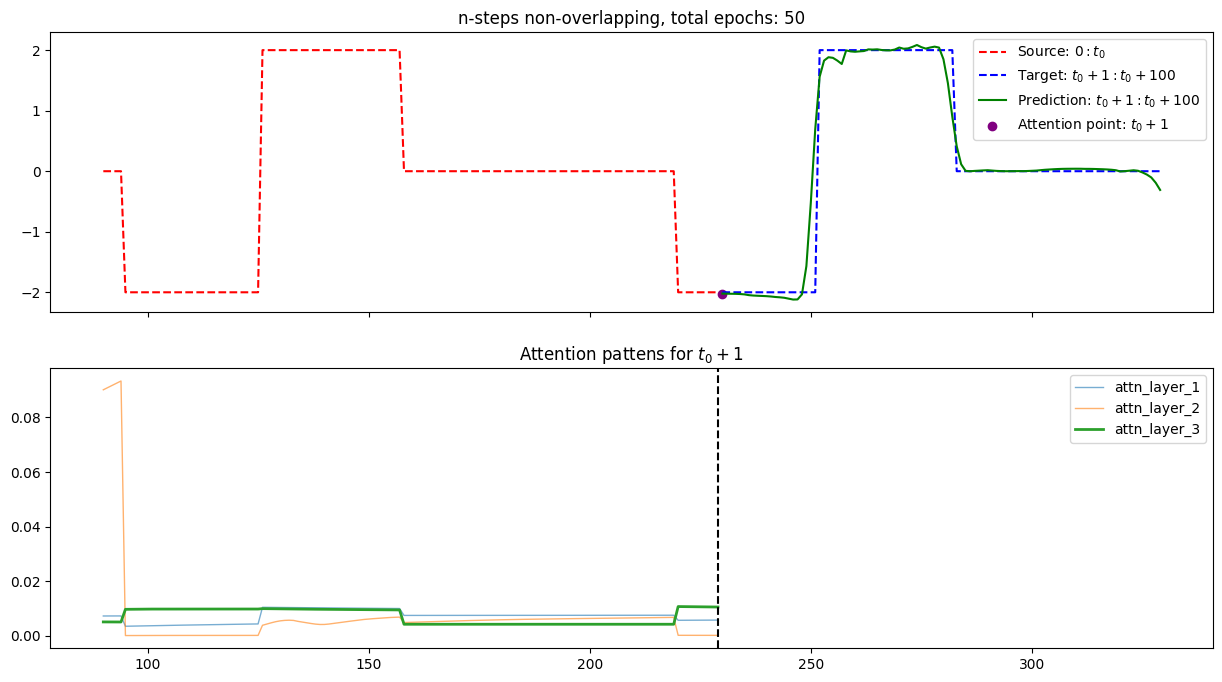

In [221]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/step_multi_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 6: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target

In [222]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 50                             # training epochs

### Sine function

#### Dataset splits

In [223]:
dataset = SD.SineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

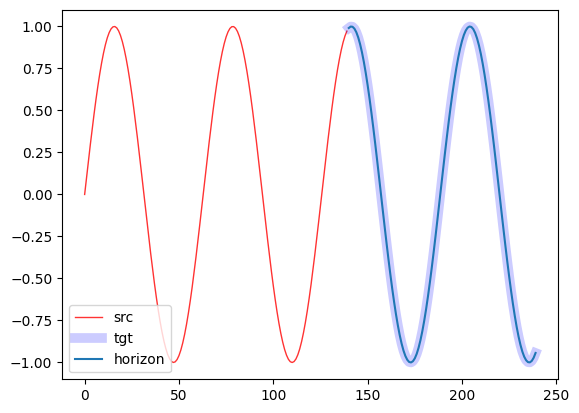

In [224]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [225]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [226]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.5620	val_loss=0.5000	R_p=['1.0000', '0.9974']
epoch=1	train_loss=0.5011	val_loss=0.5039	R_p=['1.0018', '1.0799']
epoch=2	train_loss=0.5017	val_loss=0.5038	R_p=['1.0017', '1.0789']
epoch=3	train_loss=0.5014	val_loss=0.5000	R_p=['1.0000', '1.0057']
epoch=4	train_loss=0.5014	val_loss=0.5040	R_p=['1.0021', '0.9220']
epoch=5	train_loss=0.5031	val_loss=0.5002	R_p=['1.0001', '0.9846']
epoch=6	train_loss=0.5014	val_loss=0.5024	R_p=['1.0012', '0.9396']
epoch=7	train_loss=0.5012	val_loss=0.5008	R_p=['1.0004', '0.9637']
epoch=8	train_loss=0.5017	val_loss=0.5020	R_p=['1.0009', '1.0578']
epoch=9	train_loss=0.5016	val_loss=0.5055	R_p=['1.0028', '0.9090']
epoch=10	train_loss=0.5018	val_loss=0.4999	R_p=['0.9999', '0.9946']
epoch=11	train_loss=0.5014	val_loss=0.5072	R_p=['1.0037', '0.8962']
epoch=12	train_loss=0.5005	val_loss=0.5003	R_p=['1.0000', '1.0262']
epoch=13	train_loss=0.5013	val_loss=0.5002	R_p=['0.9999', '1.0218']
epoch=14	train_loss=0.5015	val_loss=0.4998	R_p=['0.9998', 

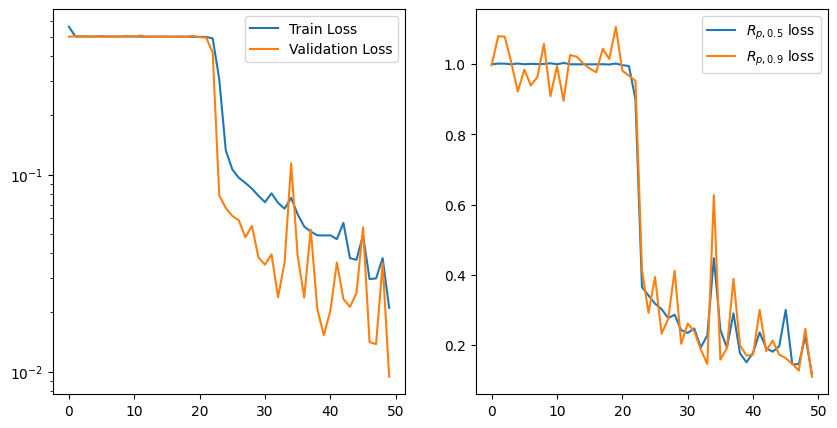

In [227]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [228]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.009214366525411606, tensor([0.1159, 0.1080], device='cuda:0'))

#### Predict

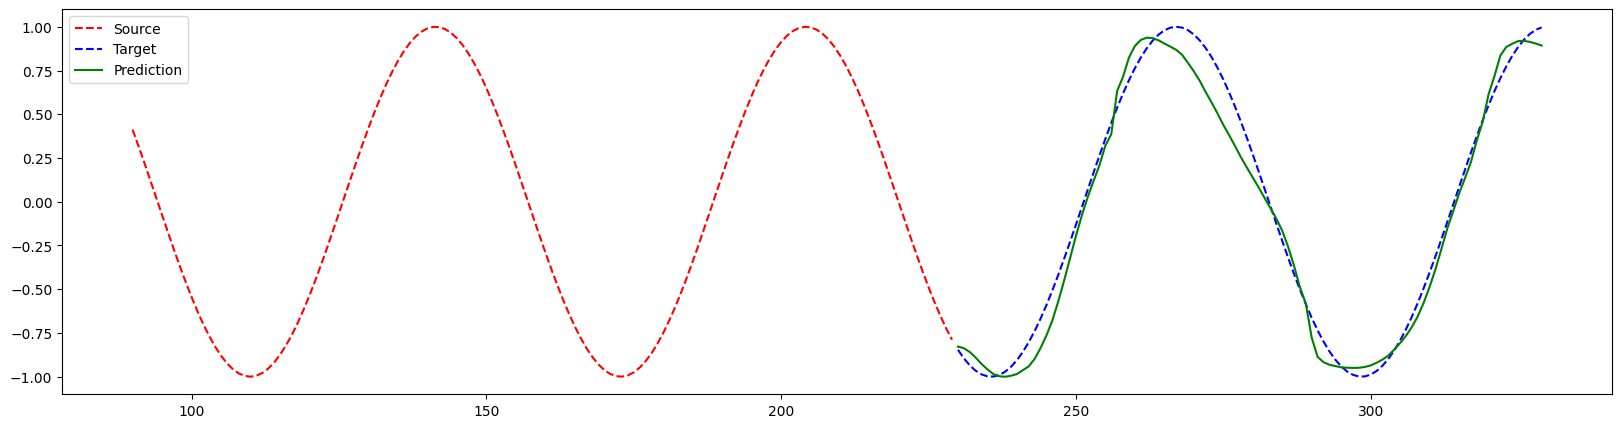

In [229]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [230]:
inspect_step = 0

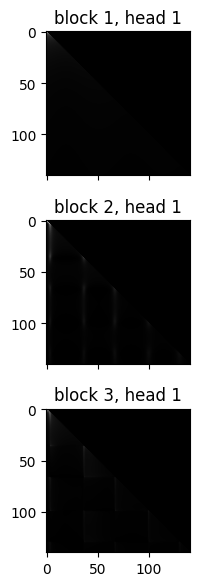

In [231]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

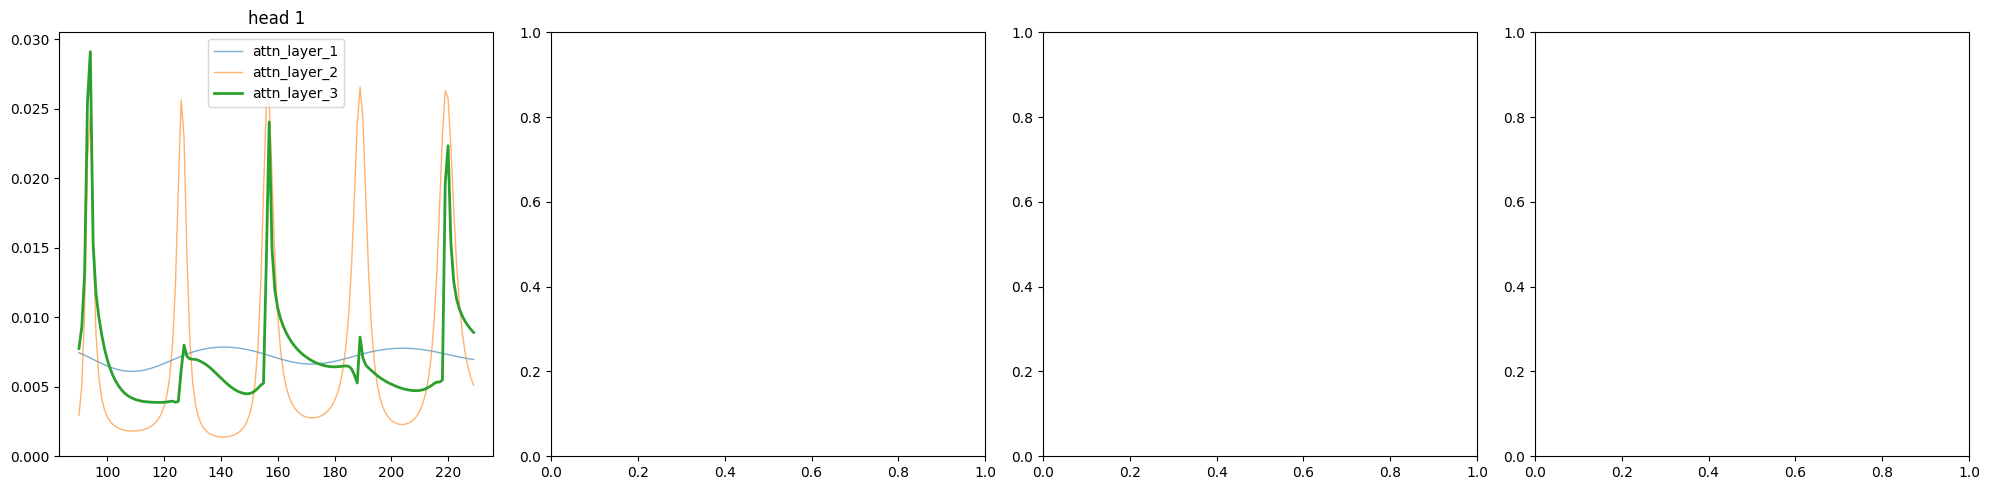

In [232]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

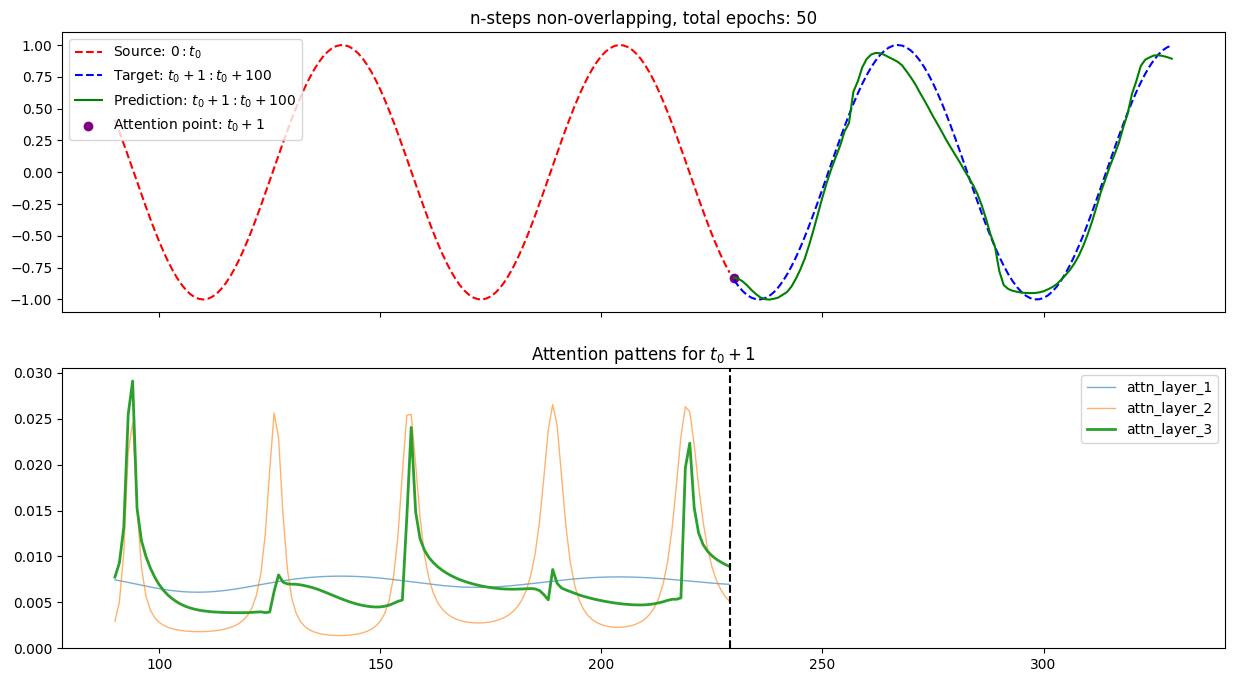

In [235]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/sine_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sine function

#### Dataset splits

In [246]:
dataset = SD.DecayingSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

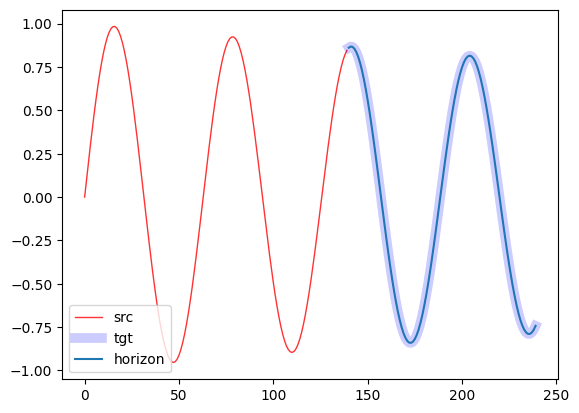

In [248]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [249]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

#### Training

In [250]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.0664	val_loss=0.0310	R_p=['1.0283', '0.9097']
epoch=1	train_loss=0.0292	val_loss=0.0309	R_p=['1.0088', '0.9362']
epoch=2	train_loss=0.0292	val_loss=0.0308	R_p=['1.0057', '1.0193']
epoch=3	train_loss=0.0292	val_loss=0.0309	R_p=['1.0165', '0.9236']
epoch=4	train_loss=0.0291	val_loss=0.0309	R_p=['1.0048', '0.9449']
epoch=5	train_loss=0.0293	val_loss=0.0314	R_p=['1.1108', '1.3241']
epoch=6	train_loss=0.0293	val_loss=0.0318	R_p=['1.1611', '1.4469']
epoch=7	train_loss=0.0293	val_loss=0.0326	R_p=['1.1953', '0.8234']
epoch=8	train_loss=0.0294	val_loss=0.0328	R_p=['1.2150', '0.8177']
epoch=9	train_loss=0.0295	val_loss=0.0330	R_p=['1.2594', '1.6741']
epoch=10	train_loss=0.0294	val_loss=0.0309	R_p=['1.0214', '1.0777']
epoch=11	train_loss=0.0291	val_loss=0.0310	R_p=['1.0483', '1.1589']
epoch=12	train_loss=0.0292	val_loss=0.0310	R_p=['1.0286', '0.9092']
epoch=13	train_loss=0.0292	val_loss=0.0308	R_p=['1.0000', '0.9708']
epoch=14	train_loss=0.0294	val_loss=0.0310	R_p=['1.0339', 

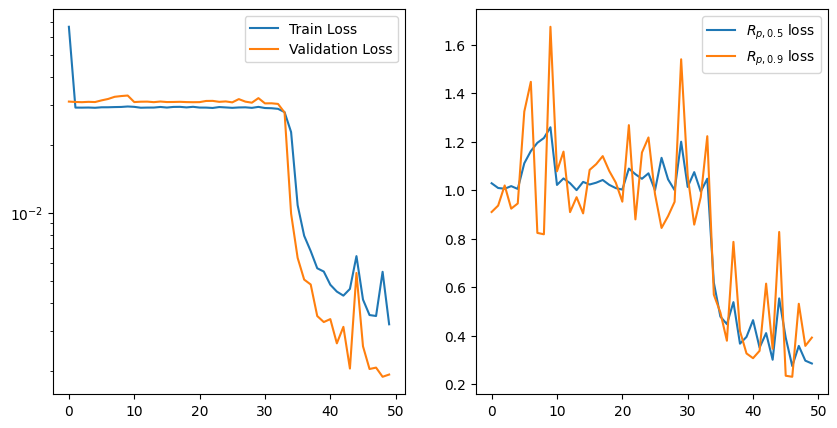

In [251]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [252]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.0018258909778669477, tensor([0.3030, 0.4039], device='cuda:0'))

#### Predict

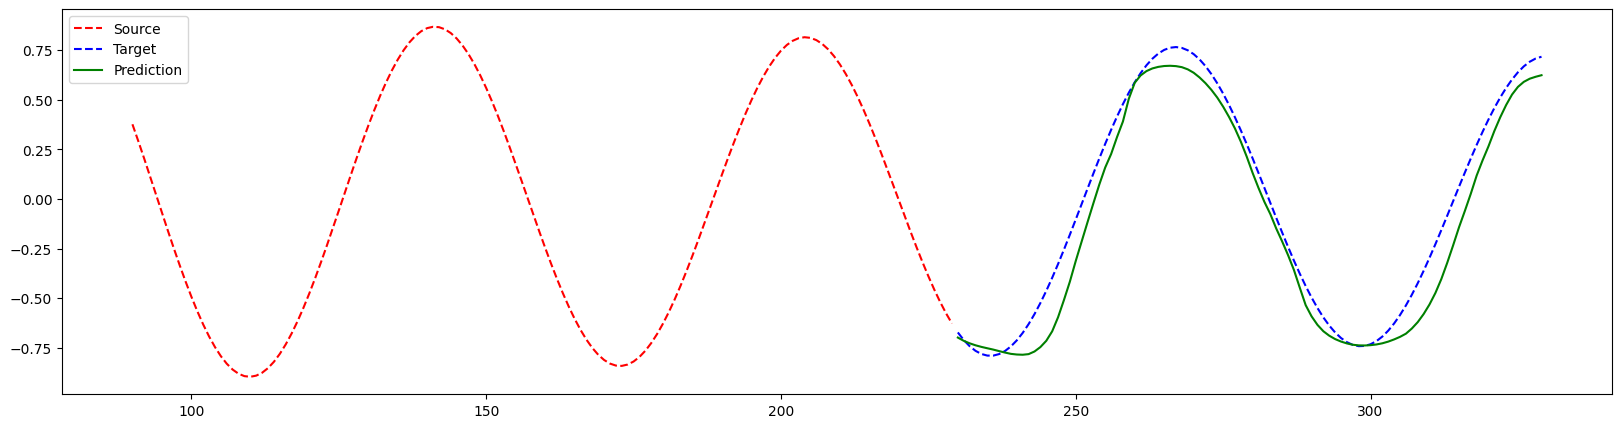

In [253]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [254]:
inspect_step = 0

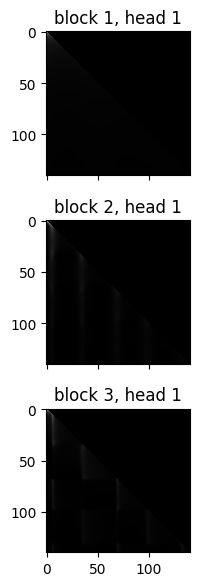

In [255]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

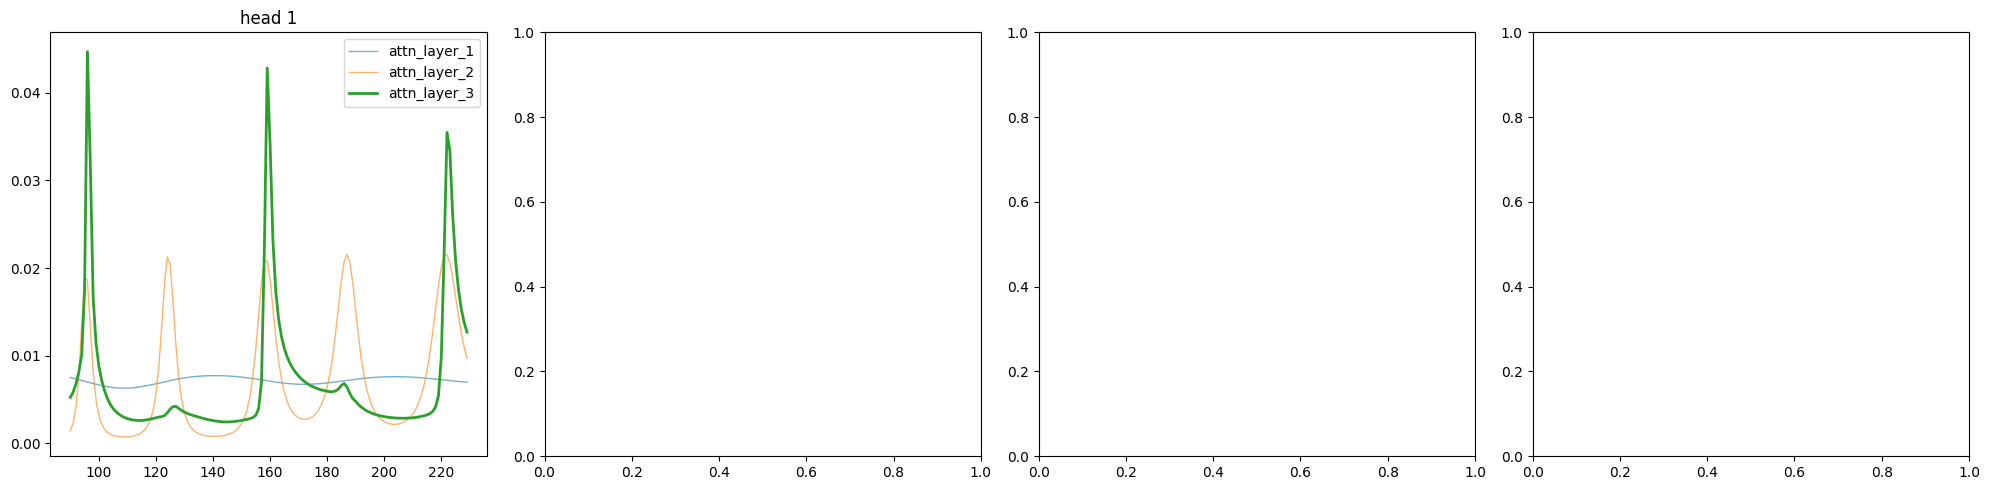

In [256]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

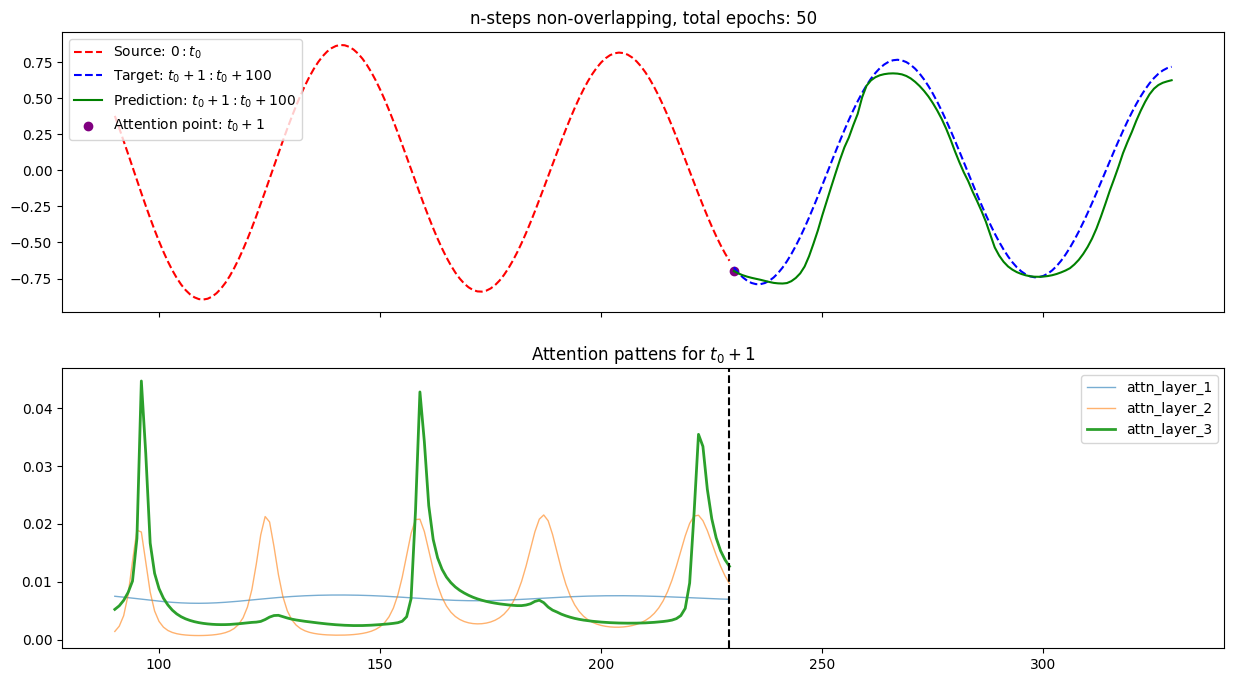

In [258]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/sine_decay_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sine function

#### Dataset splits

In [259]:
dataset = SD.MultipleSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

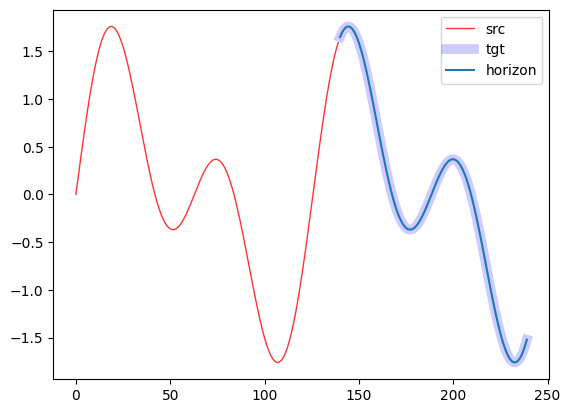

In [260]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [262]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

#### Training

In [263]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=1.0489	val_loss=0.9975	R_p=['1.0050', '1.1002']
epoch=1	train_loss=1.0036	val_loss=0.9962	R_p=['1.0037', '0.9164']
epoch=2	train_loss=1.0041	val_loss=0.9889	R_p=['1.0000', '1.0144']
epoch=3	train_loss=1.0044	val_loss=0.9889	R_p=['1.0000', '1.0127']
epoch=4	train_loss=1.0045	val_loss=0.9905	R_p=['1.0007', '0.9577']
epoch=5	train_loss=1.0038	val_loss=0.9898	R_p=['1.0005', '1.0332']
epoch=6	train_loss=1.0046	val_loss=0.9901	R_p=['1.0007', '1.0376']
epoch=7	train_loss=1.0058	val_loss=0.9895	R_p=['1.0004', '1.0285']
epoch=8	train_loss=1.0050	val_loss=0.9893	R_p=['1.0001', '0.9750']
epoch=9	train_loss=1.0030	val_loss=0.9889	R_p=['1.0000', '0.9855']
epoch=10	train_loss=1.0031	val_loss=0.9898	R_p=['1.0004', '0.9671']
epoch=11	train_loss=1.0050	val_loss=0.9888	R_p=['1.0000', '1.0105']
epoch=12	train_loss=1.0024	val_loss=0.9931	R_p=['1.0021', '0.9354']
epoch=13	train_loss=1.0030	val_loss=0.9898	R_p=['1.0006', '1.0342']
epoch=14	train_loss=1.0027	val_loss=0.9895	R_p=['1.0002', 

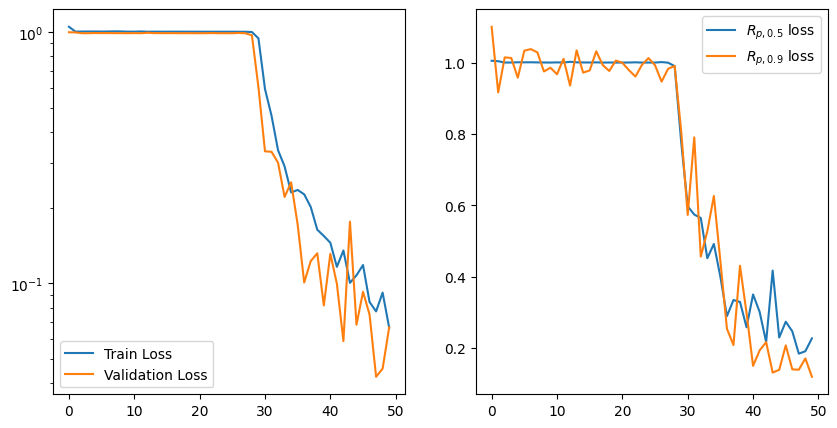

In [264]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [265]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.09270774352550507, tensor([0.2713, 0.1300], device='cuda:0'))

#### Predict

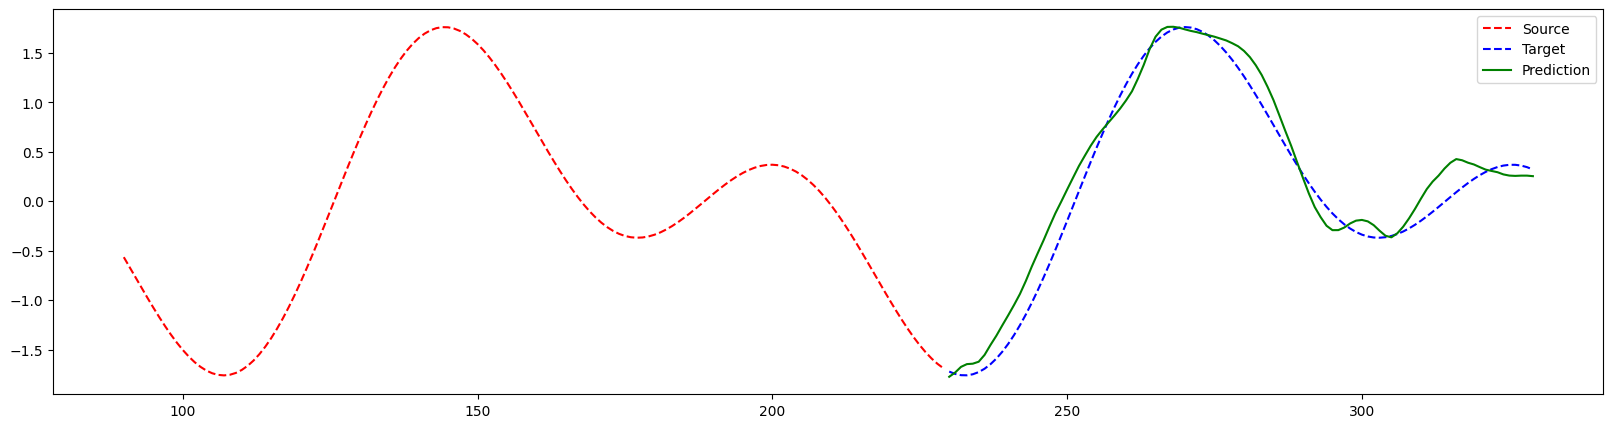

In [266]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [267]:
inspect_step = 0

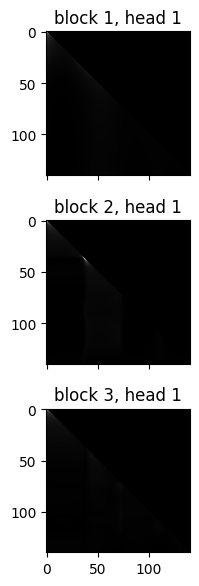

In [268]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

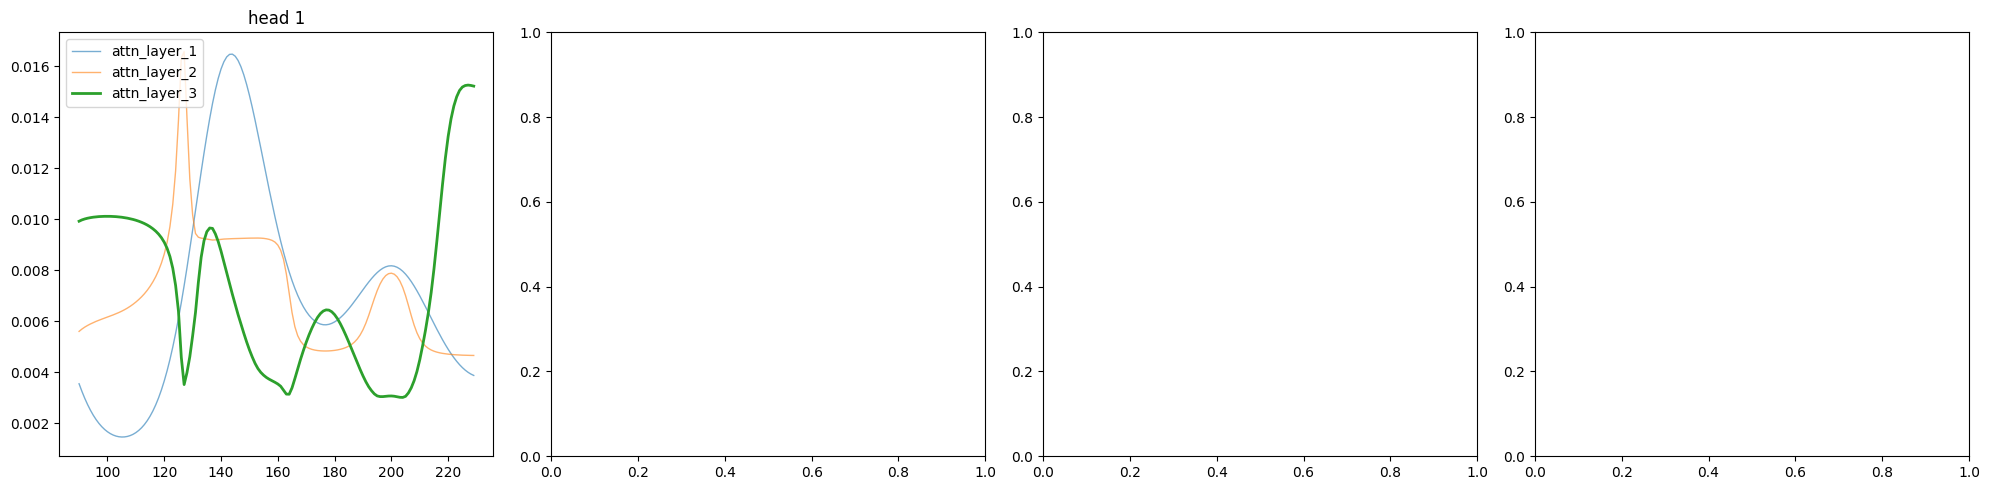

In [269]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

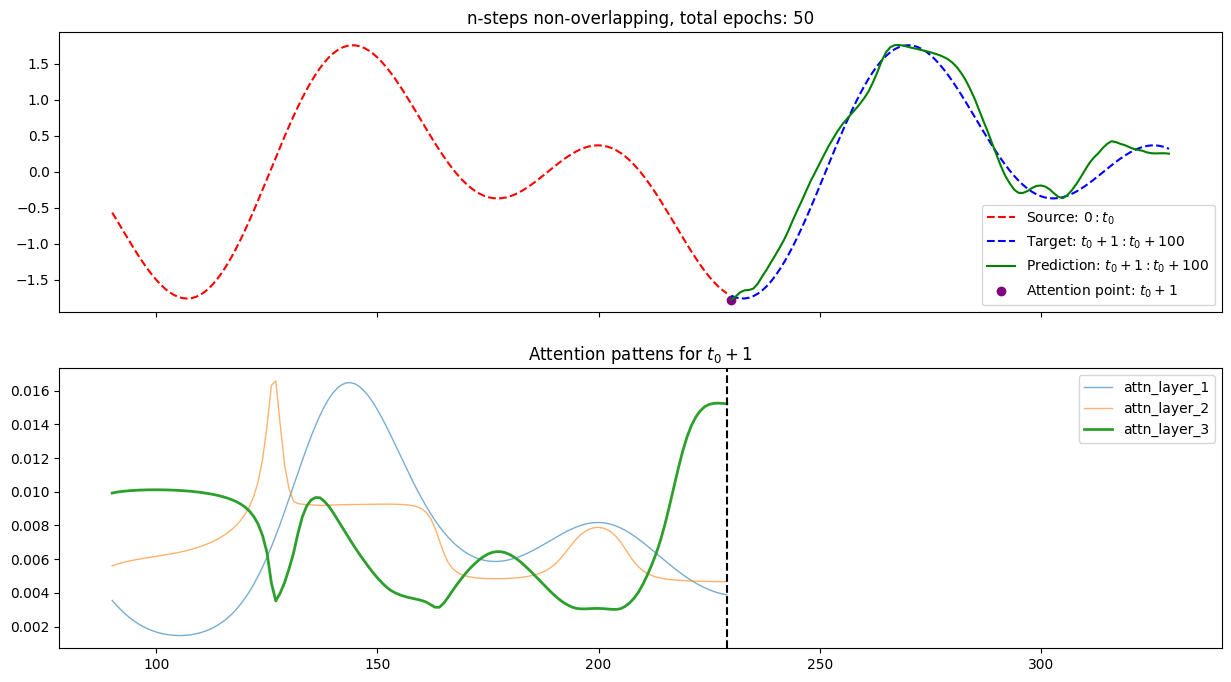

In [271]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/sine_multi_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 7: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

In [272]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 50                             # training epochs

### Sawtooth function

#### Dataset splits

In [275]:
dataset = SD.SawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, p=10, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

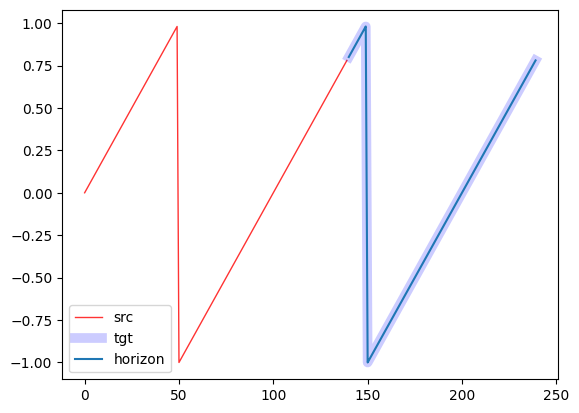

In [277]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [278]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [279]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.3849	val_loss=0.3334	R_p=['1.0000', '0.9844']
epoch=1	train_loss=0.3336	val_loss=0.3333	R_p=['1.0000', '0.9937']
epoch=2	train_loss=0.3335	val_loss=0.3333	R_p=['1.0000', '1.0016']
epoch=3	train_loss=0.3334	val_loss=0.3333	R_p=['1.0000', '1.0010']
epoch=4	train_loss=0.3334	val_loss=0.3333	R_p=['1.0000', '0.9983']
epoch=5	train_loss=0.3334	val_loss=0.3332	R_p=['0.9999', '1.0033']
epoch=6	train_loss=0.3334	val_loss=0.3332	R_p=['0.9999', '1.0027']
epoch=7	train_loss=0.3333	val_loss=0.3332	R_p=['0.9998', '0.9966']
epoch=8	train_loss=0.3333	val_loss=0.3331	R_p=['0.9997', '0.9992']
epoch=9	train_loss=0.3333	val_loss=0.3331	R_p=['0.9997', '1.0071']
epoch=10	train_loss=0.3332	val_loss=0.3329	R_p=['0.9993', '0.9958']
epoch=11	train_loss=0.3331	val_loss=0.3327	R_p=['0.9991', '0.9912']
epoch=12	train_loss=0.3328	val_loss=0.3319	R_p=['0.9978', '0.9930']
epoch=13	train_loss=0.3322	val_loss=0.3307	R_p=['0.9953', '1.0545']
epoch=14	train_loss=0.3308	val_loss=0.3066	R_p=['0.9549', 

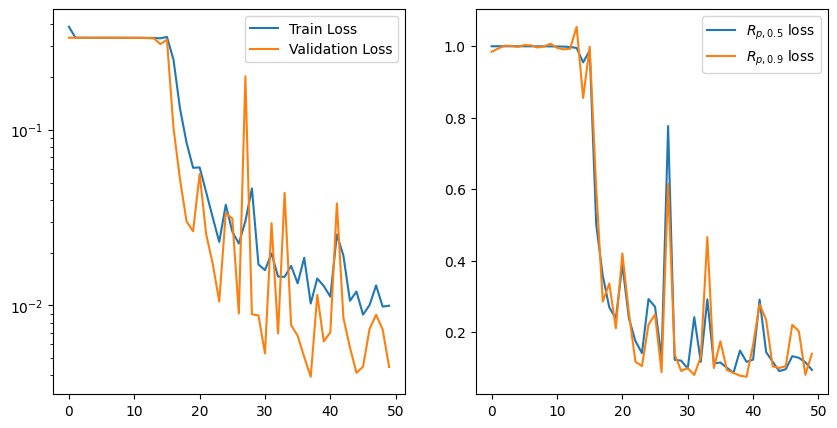

In [280]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [281]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.00447706451639533, tensor([0.0934, 0.1293], device='cuda:0'))

#### Predict

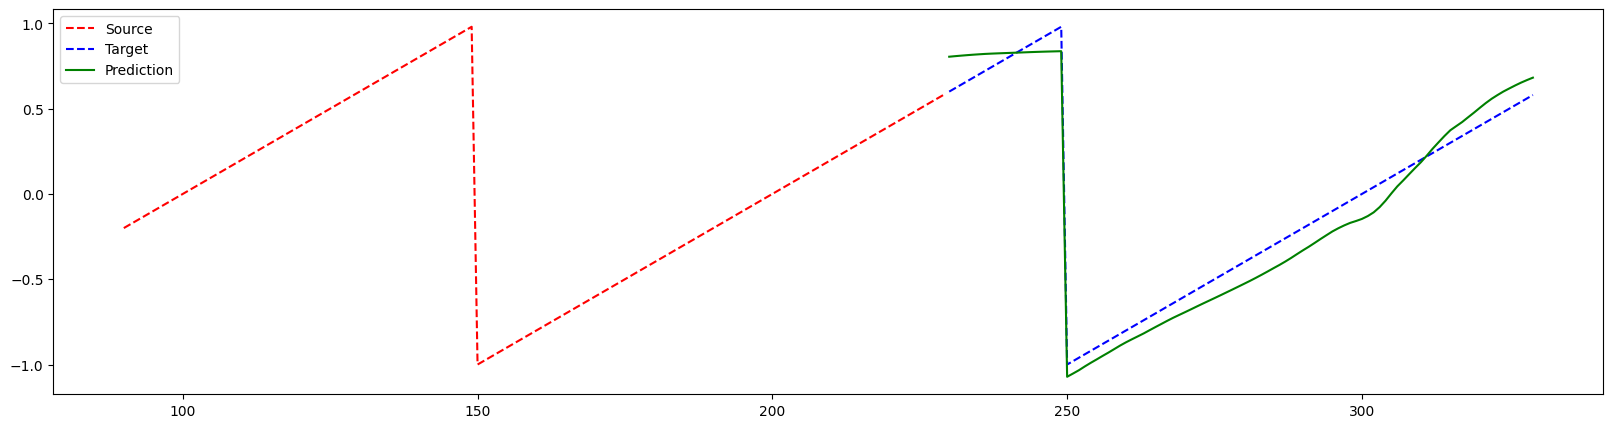

In [282]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [283]:
inspect_step = 0

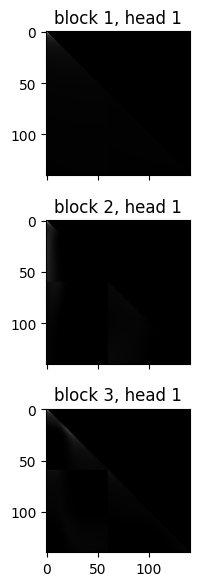

In [284]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

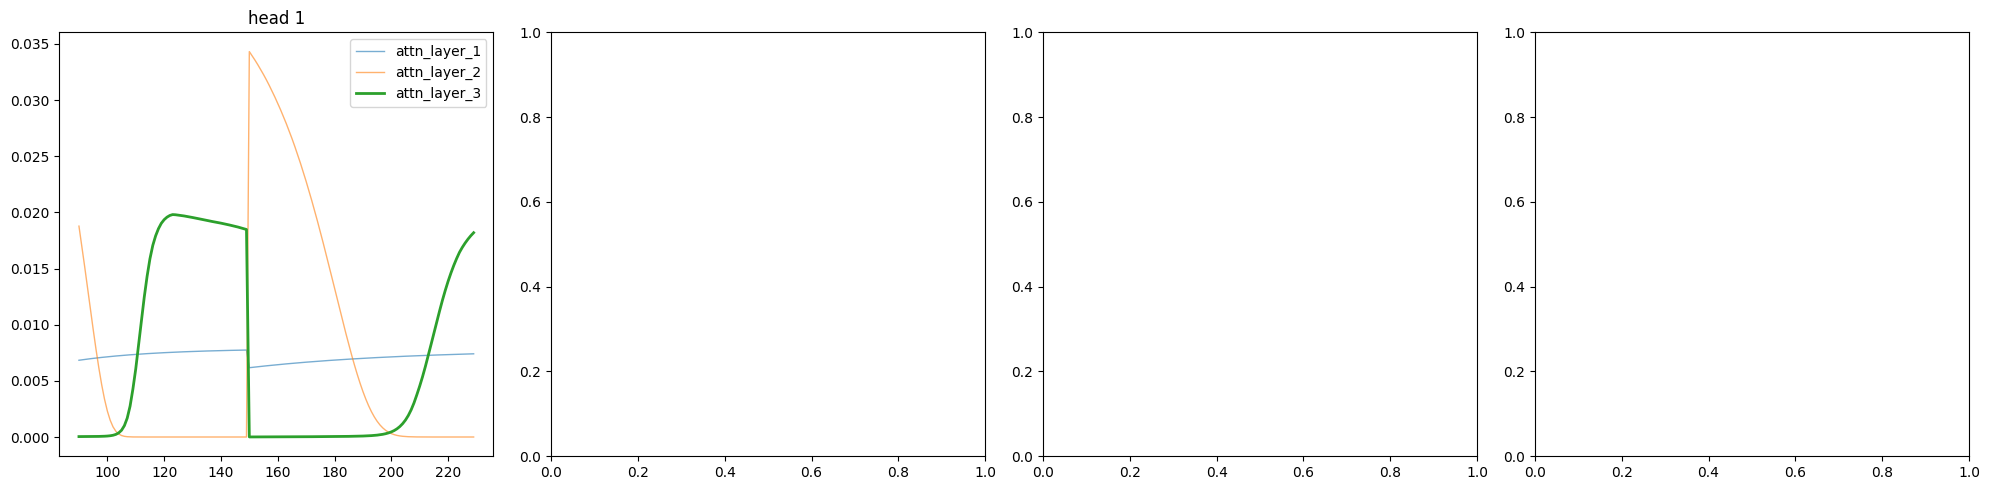

In [285]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

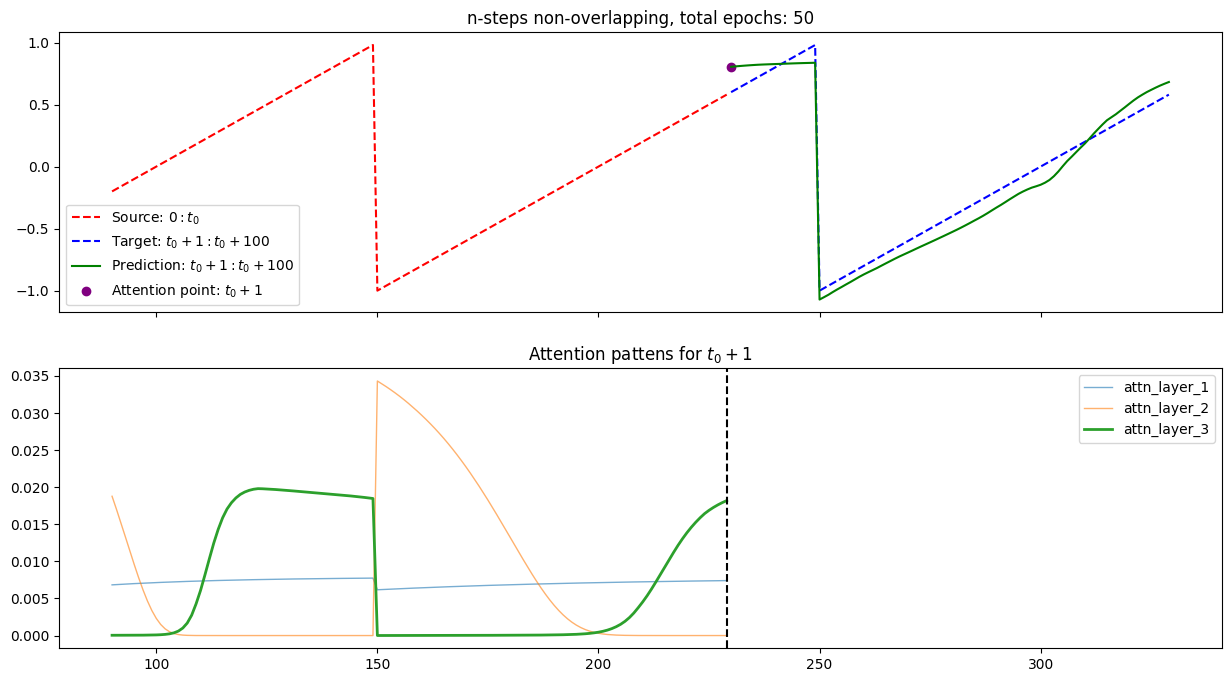

In [287]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/sawtooth_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sawtooth function

#### Dataset splits

In [296]:
dataset = SD.DecayingSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, p=10,  mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

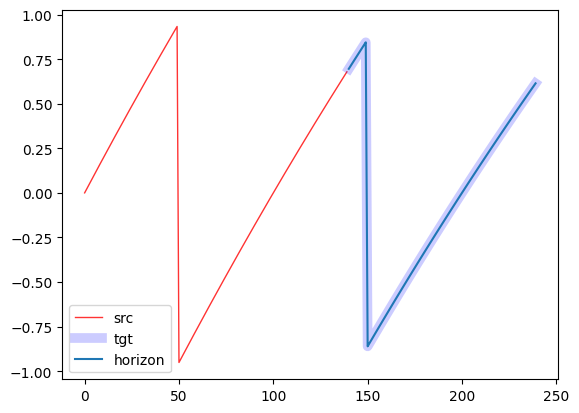

In [297]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [298]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

#### Training

In [299]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.0774	val_loss=0.0202	R_p=['1.0109', '1.0483']
epoch=1	train_loss=0.0191	val_loss=0.0203	R_p=['1.0161', '1.0667']
epoch=2	train_loss=0.0190	val_loss=0.0203	R_p=['1.0137', '1.0586']
epoch=3	train_loss=0.0190	val_loss=0.0203	R_p=['1.0126', '1.0547']
epoch=4	train_loss=0.0190	val_loss=0.0202	R_p=['1.0125', '1.0545']
epoch=5	train_loss=0.0189	val_loss=0.0202	R_p=['1.0131', '1.0566']
epoch=6	train_loss=0.0189	val_loss=0.0203	R_p=['1.0251', '1.0960']
epoch=7	train_loss=0.0189	val_loss=0.0202	R_p=['1.0029', '1.0145']
epoch=8	train_loss=0.0189	val_loss=0.0202	R_p=['1.0029', '1.0150']
epoch=9	train_loss=0.0189	val_loss=0.0202	R_p=['1.0001', '0.9939']
epoch=10	train_loss=0.0189	val_loss=0.0202	R_p=['0.9997', '0.9828']
epoch=11	train_loss=0.0189	val_loss=0.0202	R_p=['1.0005', '0.9997']
epoch=12	train_loss=0.0189	val_loss=0.0202	R_p=['1.0015', '0.9678']
epoch=13	train_loss=0.0189	val_loss=0.0202	R_p=['1.0023', '1.0133']
epoch=14	train_loss=0.0189	val_loss=0.0202	R_p=['0.9995', 

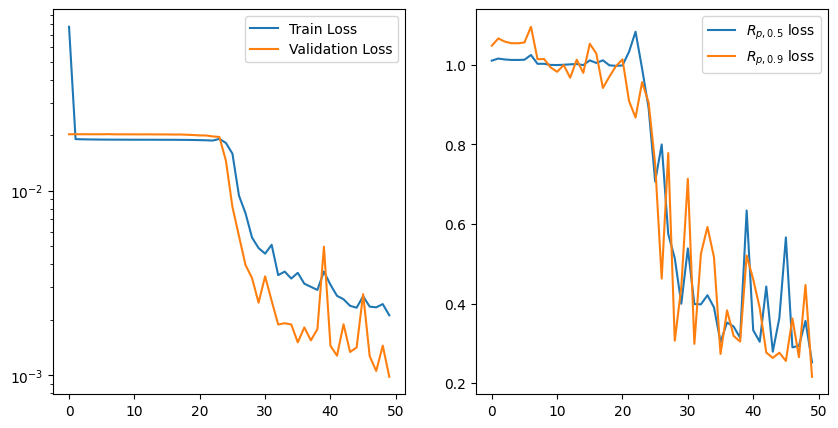

In [300]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [301]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.0009539815881289542, tensor([0.2535, 0.2216], device='cuda:0'))

#### Predict

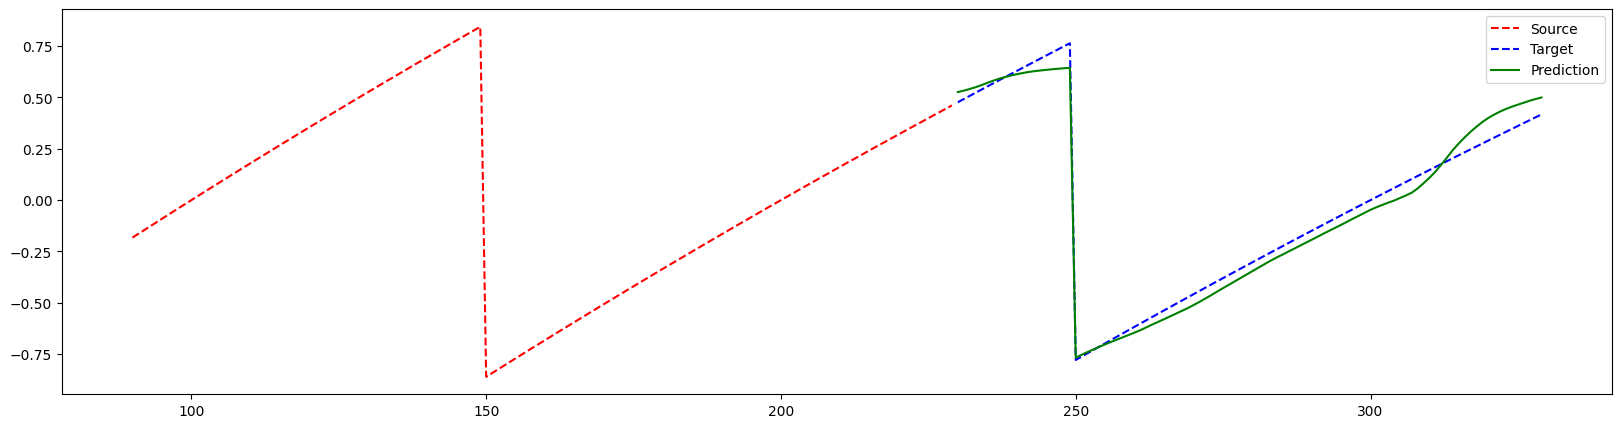

In [302]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [303]:
inspect_step = 0

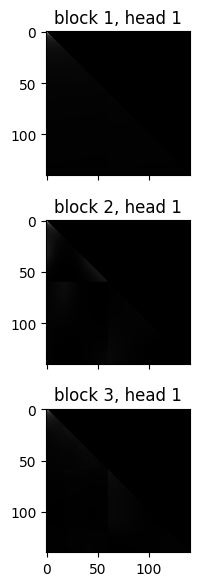

In [304]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

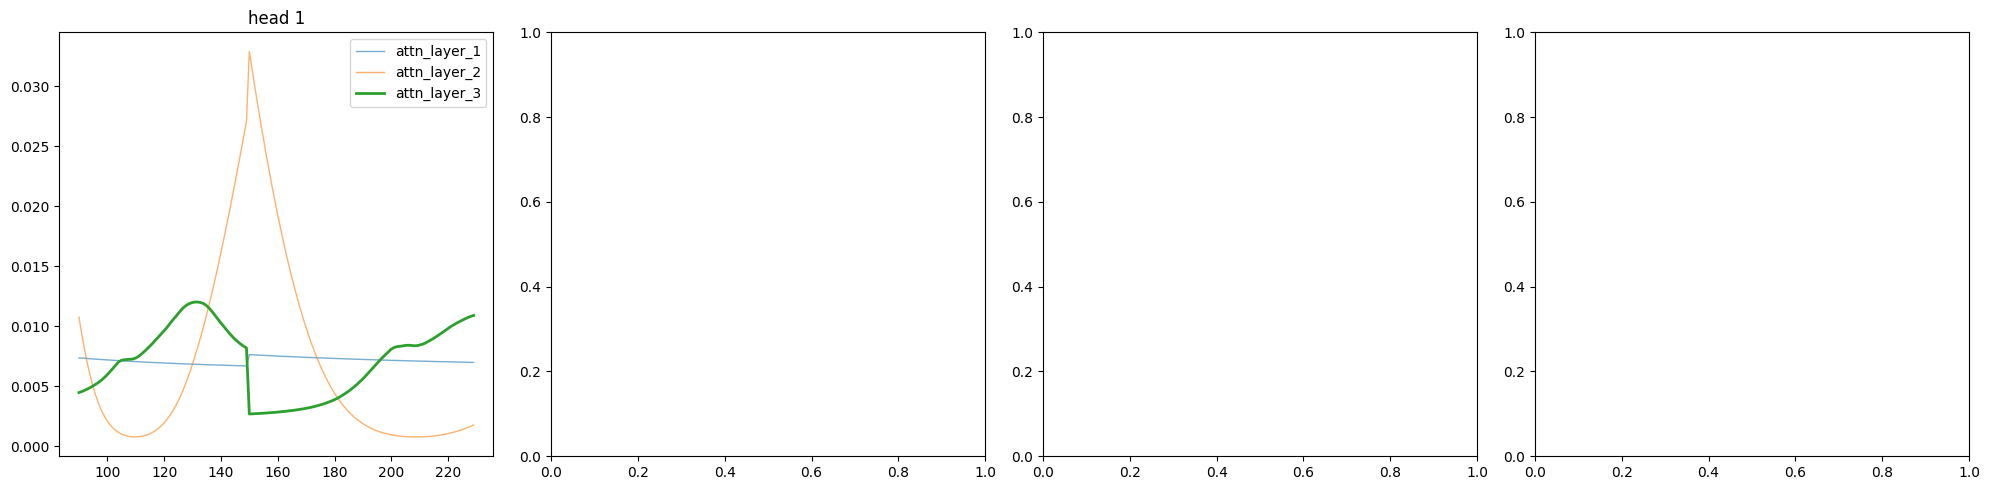

In [306]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

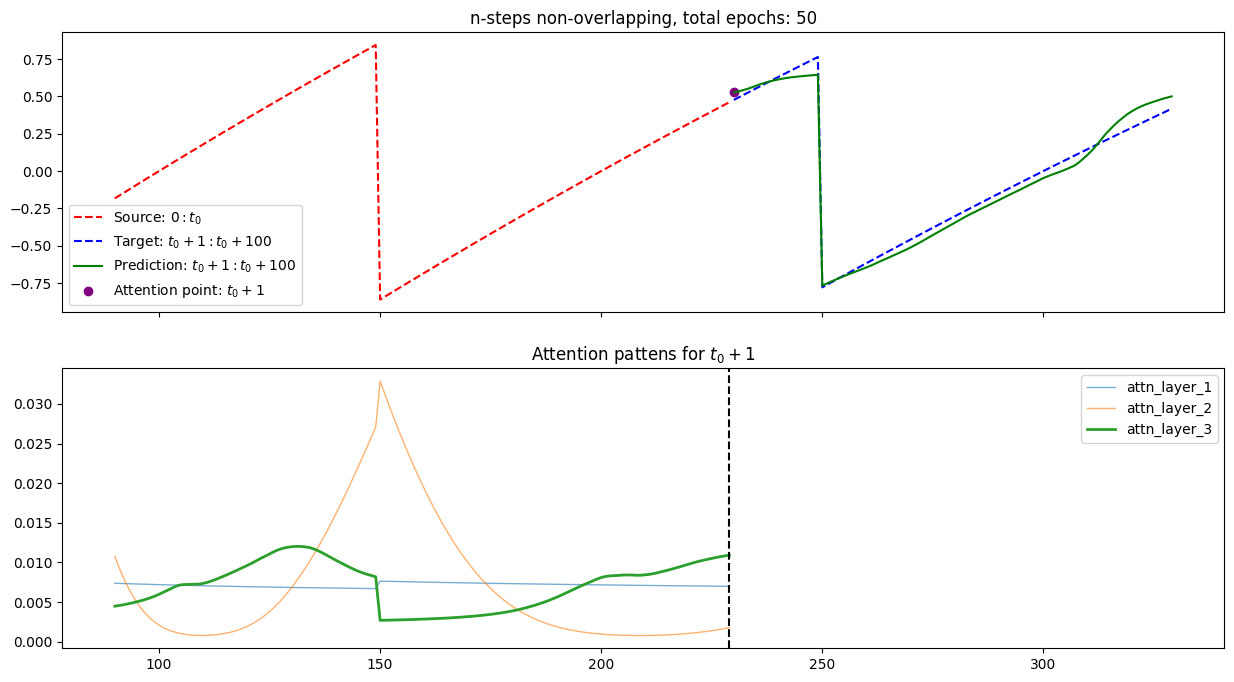

In [308]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/sawtooth_decay_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sawtooth function

#### Dataset splits

In [319]:
dataset = SD.MultipleSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, p=5, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

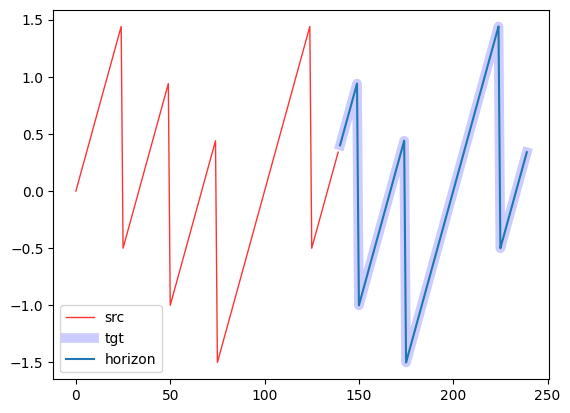

In [320]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [322]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

#### Training

In [323]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.5582	val_loss=0.4997	R_p=['0.9993', '0.9965']
epoch=1	train_loss=0.5000	val_loss=0.4997	R_p=['0.9993', '1.0005']
epoch=2	train_loss=0.4999	val_loss=0.4997	R_p=['0.9993', '1.0000']
epoch=3	train_loss=0.4998	val_loss=0.4997	R_p=['0.9993', '1.0014']
epoch=4	train_loss=0.4998	val_loss=0.4997	R_p=['0.9993', '0.9994']
epoch=5	train_loss=0.4998	val_loss=0.4996	R_p=['0.9993', '1.0013']
epoch=6	train_loss=0.4998	val_loss=0.4997	R_p=['0.9993', '1.0023']
epoch=7	train_loss=0.4998	val_loss=0.4996	R_p=['0.9992', '0.9971']
epoch=8	train_loss=0.4997	val_loss=0.4995	R_p=['0.9991', '0.9994']
epoch=9	train_loss=0.4997	val_loss=0.4994	R_p=['0.9990', '0.9983']
epoch=10	train_loss=0.4996	val_loss=0.4992	R_p=['0.9989', '0.9995']
epoch=11	train_loss=0.4995	val_loss=0.4991	R_p=['0.9987', '0.9914']
epoch=12	train_loss=0.4994	val_loss=0.4986	R_p=['0.9982', '1.0000']
epoch=13	train_loss=0.4992	val_loss=0.4979	R_p=['0.9975', '0.9943']
epoch=14	train_loss=0.4986	val_loss=0.4959	R_p=['0.9955', 

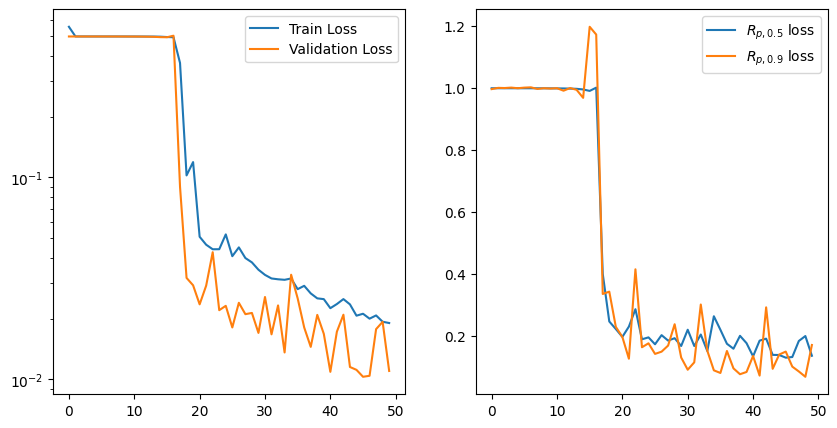

In [324]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [325]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.015971168354153634, tensor([0.1646, 0.1271], device='cuda:0'))

#### Predict

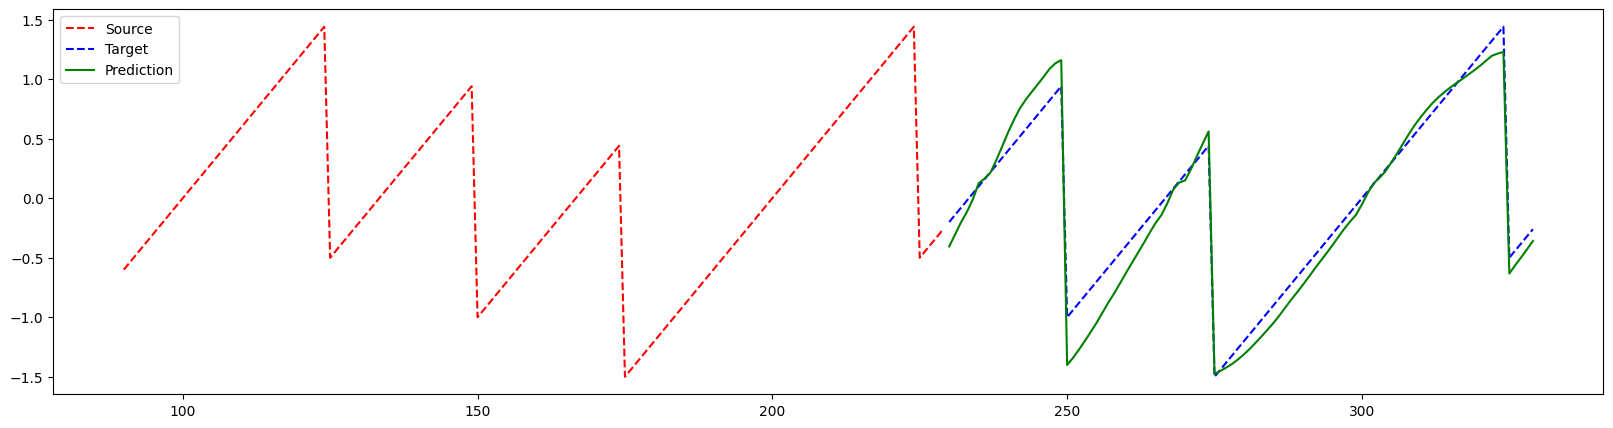

In [326]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [327]:
inspect_step = 0

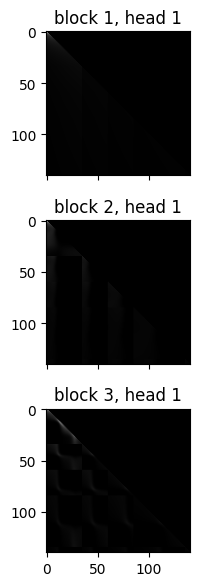

In [328]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

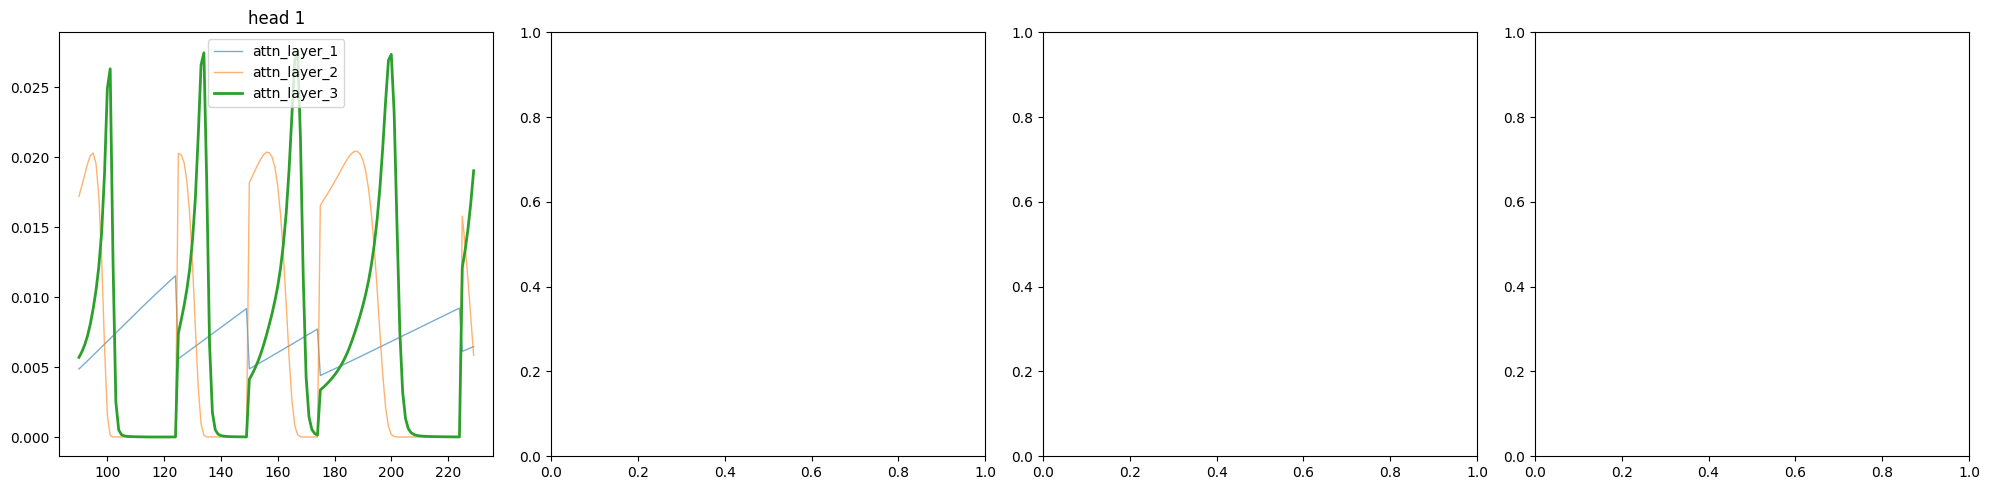

In [329]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

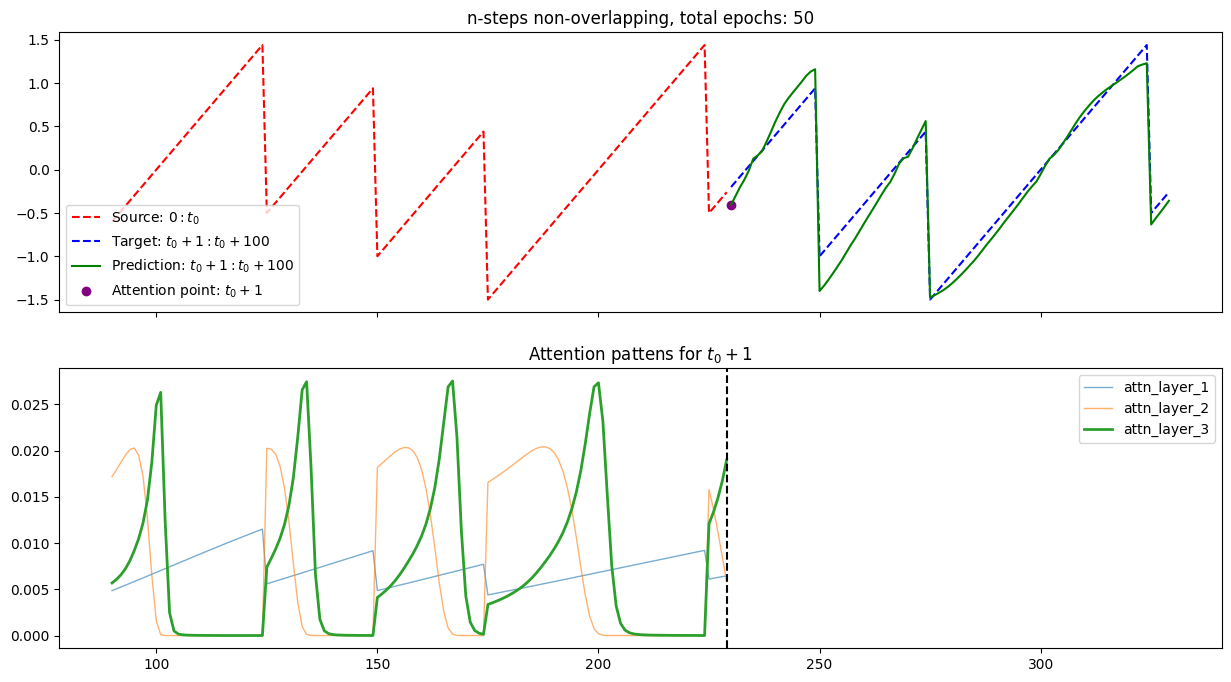

In [331]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/baseline_dec_only/sawtooth_multi_dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)